In [48]:
import requests
import random
import string
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm_notebook, tnrange
from bs4 import BeautifulSoup  
import warnings
import scipy.stats as stats
from bayes_opt import BayesianOptimization
from joblib import dump, load
import pickle
import os

import tensorflow as tf

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import sklearn.exceptions
import imblearn.under_sampling as under_sampling
import imblearn.over_sampling as over_sampling
import imblearn.combine as combine
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from sklearn import ensemble, linear_model, svm, naive_bayes, metrics, model_selection, preprocessing
import xgboost

sns.set_context("notebook")

# Hit or Not?

**Objective**: We will use the Spotify [audio features data](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) to predict whether or not a song released between 2010-2018 has appeared on the Billboard Hot 100 chart. We will train the classification algorithm on a subset of the data and test on the remainder. In principle this model could be applied to 2019 data.

The audio features consist of parameters such as danceability, energy, acousticness, tempo, and speechiness.

## Data Acquisition

### Billboard Hot 100 Tracks Data (2010-2018)

Scrape the Billboard Hot 100 Tracks (BB100) archive to acquire the song/artist that appeared in the Hot 100 at least once between 2010 and 2018. Create a data frame of artist name, song title, and the year.

We encode the level of popularity through a "rank score" (10 for 1st-10th, 9 for 11th-20th, etc.). Moreover, some tracks stayed on the BB100 for several weeks, so we put that information in the "nweeks" column. These two features are combined to create what a "popularity" measure, 

\begin{equation}
Pop = \sum_{r=1}^{R} rN_{r,\rm weeks}\;,
\end{equation}

where $r$ is the rank score ranging from 1 to 10 and $N_{\rm weeks}$ is the number of weeks the track has stayed on the BB100. A given track as a higher popularity score the higher ranking and more lasting it is on the charts.

In [2]:
redo = False
if redo:
    alltitles = []
    allartists = []
    years = []
    rscore = []
    ranknums = []
    ones = []
    for i in range(10)[::-1]:
        ranknums.extend([i+1]*10)
        
    year_list = [str(x) for x in range(2010,2019)]
    for i in tnrange(len(year_list), desc='Year'):
        
        year = year_list[i]
        page = requests.get("https://www.billboard.com/archive/charts/"+year+"/hot-100")
        soup = BeautifulSoup(page.content, "html.parser")
        
        all_dates = []
        for link in soup.select(".archive-table ")[0].find_all("a"):
            all_dates.append(link.get("href").split('/')[-1])
            
        for j in tnrange(len(all_dates), desc='Weeks', leave=False):
            page = requests.get("https://www.billboard.com/charts/hot-100/"+all_dates[j])
            soup = BeautifulSoup(page.content, "html.parser")
            
            no1title = soup.find(class_="chart-number-one__title").get_text().strip()
            no1artist = soup.find(class_="chart-number-one__artist").get_text().replace("\n","").strip()
            
            no2plusartists_tags = soup.select(".chart-list-item .chart-list-item__artist")
            no2plustitles_tags = soup.find_all(class_='chart-list-item__title-text')
            
            no2plusartists = [pt.get_text().replace("\n","").strip() for pt in no2plusartists_tags]
            no2plustitles = [pt.get_text().replace("\n","").strip() for pt in no2plustitles_tags]
            
            alltitles.extend([no1title]+no2plustitles)
            allartists.extend([no1artist]+no2plusartists)
            
            years.extend([year]*100)
            rscore.extend(ranknums)
            ones.extend([1]*100)
                   
    bbhot100_orig = pd.DataFrame({"artists":allartists, "titles":alltitles, "year":years, "rankscore":rscore, "BBhot100":ones})
    bbhot100 = bbhot100_orig.copy()
    bbhot100 = bbhot100.groupby(bbhot100.columns.tolist()).size().reset_index()
    bbhot100.columns = ['nweeks' if x==0 else x for x in bbhot100.columns]
    
    print('Writing to a file.....')
    bbhot100.to_csv('bbhot100_checkpoint1.csv', index=False)
else:
    try:
        print('Reading in file.....')
        bbhot100 = pd.read_csv('bbhot100_checkpoint1.csv')
    except:
        print("The BBhot100 data file does not exist.")

Reading in file.....


Get a unique list of artists who has ever released a BB hot 100 hit.

In [3]:
artists_w_bbhot100 = np.unique(bbhot100.artists)
print("There are {} unique artists with BB Hot 100 hits.".format(len(artists_w_bbhot100)))

There are 1995 unique artists with BB Hot 100 hits.


Compute the popularity score and add to the bbhot100 data frame.

In [4]:
popscore = bbhot100.groupby(['artists', 'titles', 'year']).apply(lambda x: sum(x.nweeks*x.rankscore))
popscore = popscore.reset_index()
popscore.columns = ['popscore' if x==0 else x for x in popscore.columns]

In [5]:
bbhot100 = bbhot100.drop_duplicates(['artists', 'titles', 'year'])
bbhot100 = bbhot100.drop(columns=['rankscore', 'nweeks'])
bbhot100 = bbhot100.reset_index(drop=True)
assert popscore.shape == bbhot100.shape
bbhot100 = bbhot100.join(popscore['popscore'])

There are some songs that appeared on the chart over two years. We need to combine those into a single entry and correct for their popscore.

In [6]:
dup = bbhot100.duplicated(subset=['artists', 'titles'], keep=False)
pairs = bbhot100[dup]

pairs_at = pairs[['titles', 'artists']].drop_duplicates()

In [7]:
#loop through the unique set of artist & tracks with duplicates
for i, row in pairs_at.iterrows():
    #get all rows with the matching artist and tracks
    p_ind = pairs.index[(pairs['titles']==row['titles'])&(pairs['artists']==row['artists'])]
    #sum the total popscore, write to the first row, drop the duplicates
    popscore_total = sum(bbhot100['popscore'].loc[p_ind])
    bbhot100['popscore'].at[p_ind[0]] = popscore_total
    bbhot100 = bbhot100.drop(axis=0, index=p_ind[1:])

In [8]:
bbhot100 = bbhot100.reset_index(drop=True)
bbhot100.head(n=10)

artists                      titles  year  \
0                   "Weird Al" Yankovic                 Word Crimes  2014   
1                              2 Chainz               I'm Different  2012   
2                              2 Chainz                   Watch Out  2016   
3                2 Chainz & Wiz Khalifa  We Own It (Fast & Furious)  2013   
4              2 Chainz Featuring Drake                      No Lie  2012   
5  2 Chainz Featuring Drake & Lil Wayne                     I Do It  2013   
6         2 Chainz Featuring Kanye West               Birthday Song  2012   
7          2 Chainz Featuring Lil Wayne                 Gotta Lotta  2016   
8          2 Chainz Featuring Lil Wayne                       Yuck!  2012   
9           2 Chainz Featuring Pharrell               Feds Watching  2013   

   BBhot100  popscore  
0         1         8  
1         1       112  
2         1        23  
3         1        34  
4         1       173  
5         1         1  
6         1        85  
7         1         1  
8         1         3  
9         1        40

In [9]:
if not Path('bbhot100_checkpoint2.csv').is_file():
    print('Writing to a file.....')
    bbhot100.to_csv('bbhot100_checkpoint2.csv', index=False)

### Spotify Data

#### BB100 song and artist data
Search the Spotify database for the artist and song ID and add the new resulting feature columns to our bbhot100 data frame. We utilize the [spotipy](https://spotipy.readthedocs.io/en/latest/#) package to access the Spotify Web API.

Some songs are collaborations between multiple artists. Use only the primary artist (first name listed) to search for the tracks. About 1% of the songs are not matched in the Spotify database mainly because the artist (e.g., Jay Z) has not made the particular song available for streaming on Spotify. In a few cases, there are mismatches in name styling: we will not go through and manually check/change these cases.

In [10]:
client_credentials_manager = SpotifyClientCredentials(client_id='XXXXXX', client_secret='XXXXXX')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [11]:
redo = False
if redo:
    artists_sp_id = []
    tracks_sp_id = []
    join_chars = [' Featuring ', ' With ', ' Feauring ', ' / ', ' & ', ' x ', ' X ', ' + ', ' Duet ', ', ', ' And ', ' Vs ', ' vs ']
    
    for i_a in tnrange(len(bbhot100.artists), desc='BB100'):
                
        #try the artist name as is
        try:
            artist_query = bbhot100.artists[i_a]
            
            #avoiding manual intervention as much as possible except for these
            if artist_query == 'Ke$ha':
                artist_query = 'Kesha'
            if artist_query == 'ROCKMAFIA':
                artist_query = 'Rock Mafia'
            if artist_query == "Soulja Boy Tell'em":
                artist_query = 'Soulja Boy'
    
            artist = sp.search(q="artist:'"+artist_query+"'", type='artist', limit=1)
            aid = artist["artists"]["items"][0]["id"].strip()
            
            artists_sp_id.append(aid)
    
        except:
            for i_c, char in enumerate(join_chars):
                try:
                    #try a different version of the name
                    artist_query = bbhot100.artists[i_a].split(char)[0].strip()
                    artist = sp.search(q="artist:'"+artist_query+"'", type='artist', limit=1)
                    aid = artist["artists"]["items"][0]["id"].strip()
    
                    artists_sp_id.append(aid)
                    break
                except:
                    if i_c < (len(join_chars)-1):
                        continue
                    else:
                        print(i_a, artist_query, 'could not be matched in the Spotify database.')
                        artists_sp_id.append("9"*10)
            
        try:
            #sometimes the top returned result isn't actually the original song and instead is a cover, remix, etc.
            #choose the one with the highest popularity score according to Spotify out of three results
            track = sp.search(q="track:'"+bbhot100.titles[i_a]+"' artist:'"+artist_query+"'", type='track', limit=3)
            maxpopind = np.argmax([track['tracks']['items'][x]['popularity'] for x in range(len(track['tracks']['items']))])
            tracks_sp_id.append(track["tracks"]["items"][maxpopind]["id"].strip())
        except:
            try:
                track = sp.search(q="track:'"+bbhot100.titles[i_a].split('(')[0].strip()+"' artist:'"+artist_query+"'", type='track', limit=3)
                maxpopind = np.argmax([track['tracks']['items'][x]['popularity'] for x in range(len(track['tracks']['items']))])
                tracks_sp_id.append(track["tracks"]["items"][maxpopind]["id"].strip())
            except:
                try:
                    track = sp.search(q="track:'"+bbhot100.titles[i_a].split('-')[0].strip()+"' artist:'"+artist_query+"'", type='track', limit=3)
                    maxpopind = np.argmax([track['tracks']['items'][x]['popularity'] for x in range(len(track['tracks']['items']))])
                    tracks_sp_id.append(track["tracks"]["items"][maxpopind]["id"].strip())
                except:
                    try:
                        track = sp.search(q=bbhot100.titles[i_a]+" artist:'"+artist_query, type='track', limit=3)
                        maxpopind = np.argmax([track['tracks']['items'][x]['popularity'] for x in range(len(track['tracks']['items']))])
                        tracks_sp_id.append(track["tracks"]["items"][maxpopind]["id"].strip())
                    except:
                        print(i_a, bbhot100.titles[i_a], 'by', artist_query, 'could not be matched in the Spotify database.')
                        tracks_sp_id.append("9"*10)
    
    #save a unique list of IDs for artists with BB 100 hits
    allartists_sp_id = np.unique(artists_sp_id)
                    
    if len(artists_sp_id) == np.shape(bbhot100)[0]:
        bbhot100['artists_sid'] = artists_sp_id
        bbhot100['tracks_sid'] = tracks_sp_id
    else:
        print("Number of samples doesn't line up")
    
    print('Missing',sum((bbhot100.tracks_sid=='9'*10)|(bbhot100.artists_sid=='9'*10)),'out of',len(bbhot100.tracks_sid),'songs')
    
    #We will drop non-matches which comprise a small fraction of the whole sample.
    bbhot100 = bbhot100.drop(bbhot100[bbhot100.tracks_sid == '9'*10].index)
    bbhot100 = bbhot100.drop(bbhot100[bbhot100.artists_sid == '9'*10].index)
    bbhot100 = bbhot100.reset_index(drop=True)
    print('Missing',sum((bbhot100.tracks_sid=='9'*10)|(bbhot100.artists_sid=='9'*10)),'out of',len(bbhot100.artists_sid),'songs')

In [12]:
if not Path('bbhot100_checkpoint3.csv').is_file():
    print('Writing to a file.....')
    bbhot100.to_csv('bbhot100_checkpoint3.csv', index=False)
else:
    print('Reading in file.....')
    bbhot100 = pd.read_csv('bbhot100_checkpoint3.csv')
    
if not Path('allartists_sp_id.csv').is_file():
    with open('allartists_sp_id.csv', 'w') as fname:
            wr = csv.writer(fname)
            for spid in allartists_sp_id:
                wr.writerow([spid])
else:
    with open('allartists_sp_id.csv', 'r') as fname:
        wr = csv.reader(fname)
        allartists_sp_id = [row[0] for row in wr] 

Reading in file.....


Use the Spotify track ids to obtain the ["Audio Features"](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) data, then change the data types from object to appropriate choices, and save to a csv.

In [13]:
colnames2add = sp.audio_features(tracks=bbhot100.tracks_sid[0])[0].keys()
colnames2add = [x for x in colnames2add if x not in ['analysis_url','id','track_href','type','uri']]
bbhot100_af = pd.concat([bbhot100, pd.DataFrame(columns=colnames2add)], sort=False)           

In [14]:
redo = False
if redo:
    for i_t in tnrange(len(bbhot100_af.artists), desc='Audio Features'):
        
        try:
            t = bbhot100_af.tracks_sid[i_t]
            audio_feats = sp.audio_features(tracks=t)[0]
            
            [audio_feats.pop(x, None) for x in ['analysis_url','id','track_href','type','uri']]
            bbhot100_af.loc[i_t, colnames2add] = audio_feats.values()
        except:
            print(t, audio_feats)
    
    int_cols = ['year', 'duration_ms', 'key', 'mode', 'time_signature', 'BBhot100']
    bbhot100_af[int_cols] = bbhot100_af[int_cols].astype('int')
    flt_cols = ['popscore', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo']
    bbhot100_af[flt_cols] = bbhot100_af[flt_cols].astype('float')
    
    bbhot100_af = bbhot100_af.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    if not Path('bbhot100_checkpoint4.csv').is_file():
        print('Writing to a file.....')
        bbhot100_af.to_csv('bbhot100_checkpoint4.csv', index=False)
else:
    try:
        print('Reading in file.....')
        bbhot100_af = pd.read_csv('bbhot100_checkpoint4.csv')
    except:
        print("The BBhot100 data file does not exist.")
    

Reading in file.....


In [15]:
bbhot100_af.head()

artists                      titles  year  BBhot100  \
0       "Weird Al" Yankovic                 Word Crimes  2014         1   
1                  2 Chainz               I'm Different  2012         1   
2                  2 Chainz                   Watch Out  2016         1   
3    2 Chainz & Wiz Khalifa  We Own It (Fast & Furious)  2013         1   
4  2 Chainz Featuring Drake                      No Lie  2012         1   

   popscore             artists_sid              tracks_sid  danceability  \
0       8.0  1bDWGdIC2hardyt55nlQgG  4JqQWAr47pGEoaMArpA7Z3         0.897   
1     112.0  17lzZA2AlOHwCwFALHttmp  6J5sxraPPZ4b0CVOGAgpXj         0.936   
2      23.0  17lzZA2AlOHwCwFALHttmp  22DKsoYFV5npPXmnPpXL7i         0.901   
3      34.0  17lzZA2AlOHwCwFALHttmp  00QyLmjxaSEE8qIZQjBXBj         0.554   
4     173.0  17lzZA2AlOHwCwFALHttmp  6j9iyrrmqWlQZ5SD1hSTaq         0.634   

   energy  key  loudness  mode  speechiness  acousticness  instrumentalness  \
0   0.430    7   -12.759     1       0.0551        0.0118               0.0   
1   0.702   10    -5.305     1       0.0615        0.0473               0.0   
2   0.509    8    -6.777     0       0.4920        0.8420               0.0   
3   0.899    8    -4.573     1       0.4080        0.0521               0.0   
4   0.665    6    -5.984     0       0.1760        0.0172               0.0   

   liveness  valence    tempo  duration_ms  time_signature  
0    0.0473    0.964  121.987       223120               4  
1    0.0838    0.704   97.524       207040               4  
2    0.0531    0.544  129.924       207813               4  
3    0.0568    0.552  171.966       227893               4  
4    0.3650    0.611  131.108       237827               4

#### Other song and artist data

We obtain random songs on the Spotify database between 2010 and 2018 to achieve a ratio of almost 100:1 between non-hits and hits. There are two reasons for this choice. First, hits are very rare (even 100:1 is an underestimate) and this is meant to be an approximate representation of this phenomenon, and two, we want to create a data set appropriate for applying machine learning on a very imbalanced data set (just for practice!).

Start with the data frame containing BB100 tracks and artists data.

In [16]:
client_credentials_manager = SpotifyClientCredentials(client_id='XXXXXX', client_secret='XXXXXX')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Obtain random tracks released between 2010-2018 and add to the new empty data frame.

In [17]:
redo = False
if redo:
    num_it = 5000
    year_list = [str(x) for x in range(2010,2019)]
    
    row_list = []
    for y in tnrange(len(year_list), desc='Year'):    
        year = year_list[y]
        
        for i_l in tnrange(num_it, desc='Tracks', leave=False):
            
            #try to get a random song
            t = None
            while t == None:
                try:
                    #get a list of tracks starting with the randomly chosen letter
                    random_let = random.choice(string.ascii_letters)
                    random_int = random.randint(0, 10000)
                    tracks = sp.search(q='track:'+random_let+" year:"+str(year), type='track', limit=1, offset=random_int)
                    t = tracks['tracks']['items'][0]
                    
                    #look up the audio features for the random track
                    audio_feats = sp.audio_features(tracks=t['id'])[0]
                    [audio_feats.pop(x, None) for x in ['analysis_url','id','track_href','type','uri']]
                    row = {'artists': t['artists'][0]['name'], 'titles': t['name'], 'year': year, \
                            'popscore': 0, 'artists_sid': t['artists'][0]['id'], 'tracks_sid': t['id'], \
                            **audio_feats, 'BBhot100':0}
                    row_list.append(row)
                except:
                    pass            
                
    non_bbhot100_af = pd.DataFrame(row_list)
    
    int_cols = ['year', 'duration_ms', 'key', 'mode', 'time_signature']
    non_bbhot100_af[int_cols] = non_bbhot100_af[int_cols].astype('int')
    flt_cols = ['popscore', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo']
    non_bbhot100_af[flt_cols] = non_bbhot100_af[flt_cols].astype('float')
    
    non_bbhot100_af = non_bbhot100_af.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    non_bbhot100_af.dropna(inplace=True)
    
    if not Path('non_bbhot100_checkpoint1.csv').is_file():
        print('Writing to a file.....')
        non_bbhot100_af.to_csv('non_bbhot100_checkpoint1.csv', index=False)
else:
    try:
        non_bbhot100_af = pd.read_csv('non_bbhot100_checkpoint1.csv')
    except:
        print("The non_BBhot100 data file does not exist.")
        

In [18]:
non_bbhot100_af.head()

BBhot100  acousticness                 artists             artists_sid  \
0         0       0.92300  Georg Philipp Telemann  2fg5h5pzleqI4RjFopWroj   
1         0       0.94800        Richard Tognetti  0kdjTXFwhF9w9Cuscbgccu   
2         0       0.00527       Don Gorda Project  7msx2SnES7JphRLoX9rpqU   
3         0       0.99200         Gunnar Eriksson  5DjHZuzlVL4pi9sImM8bHG   
4         0       0.02590      D. J. Party Fiesta  1eU2kucAV9LHIk7gJWTnqJ   

   danceability  duration_ms  energy  instrumentalness  key  liveness  \
0        0.4320       352040  0.1740            0.0155    3    0.1040   
1        0.0717       319880  0.0245            0.5880    0    0.1520   
2        0.8190       346240  0.7410            0.9000    5    0.0774   
3        0.1630       336760  0.1410            0.0152   10    0.0825   
4        0.7040       217288  0.9200            0.0000    9    0.1960   

   loudness  mode  popscore  speechiness    tempo  time_signature  \
0   -18.962     0         0       0.0400  114.727               4   
1   -30.045     0         0       0.0470   75.624               3   
2    -8.697     0         0       0.0527  159.960               4   
3   -22.663     1         0       0.0372   86.487               4   
4    -9.602     0         0       0.0399  126.028               4   

                                              titles              tracks_sid  \
0  Overture & Suite in E Minor "Tafelmusik" for 2...  4mEdwJv0aIfuOqr8J2FRBM   
1  2 Melodies hebraiques (R. Tognetti): No. 1. Ka...  46qkjfNFysM2khnZmb3AKm   
2                                     Bossa ´n´ Jazz  6J2RaVyjF2MTwFRZefdz7q   
3   Nu ar kommen den lyckliga tid (arr. G. Eriksson)  2028fumaTE7py1DgG6BTbr   
4                                 Rhythm Is A Dancer  6sC2MuF4oVnVXnef6RVGMh   

   valence  year  
0   0.3250  2010  
1   0.0394  2010  
2   0.9530  2010  
3   0.0558  2010  
4   0.6950  2010

#### Combining the two data sets
Combine the two data frames to get a mix of BB100 hit and non-hit songs.

In [19]:
allsongs_af = pd.concat([bbhot100_af, non_bbhot100_af], sort=False)

Add one more feature column, 1 or 0 depending on if the artist has ever had a hit song on the BB100 chart.

In [20]:
allsongs_af['BBhot100_history'] = allsongs_af['artists_sid'].apply(lambda x: 1 if x in allartists_sp_id else 0)

Basic checks for duplicates, data types, NaNs, etc.

In [21]:
print('Any duplicates? {}'.format(allsongs_af.duplicated().any()))
print('Number of duplicate songs:{:4}'.format(len(allsongs_af[allsongs_af.duplicated(keep='first')])))

if allsongs_af.duplicated().any():
    print('Removing duplicates.....')
    allsongs_af.drop_duplicates(inplace=True)
    
    print('Any duplicates? {}'.format(allsongs_af.duplicated().any()))
    print('Number of duplicate songs:{:4}'.format(len(allsongs_af[allsongs_af.duplicated(keep='first')])))

Any duplicates? True
Number of duplicate songs: 935
Removing duplicates.....
Any duplicates? False
Number of duplicate songs:   0


In [22]:
count_null_values = allsongs_af.isnull().sum().sort_values(ascending=False)
print(count_null_values)

allsongs_af.dropna(inplace=True)
count_null_values = allsongs_af.isnull().sum().sort_values(ascending=False)
print(count_null_values)

artists             1
titles              1
key                 0
year                0
BBhot100            0
popscore            0
artists_sid         0
tracks_sid          0
danceability        0
energy              0
BBhot100_history    0
time_signature      0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
loudness            0
dtype: int64
BBhot100_history    0
key                 0
titles              0
year                0
BBhot100            0
popscore            0
artists_sid         0
tracks_sid          0
danceability        0
energy              0
loudness            0
time_signature      0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
artists             0
dtype: int64


In [23]:
allsongs_af.dtypes

artists              object
titles               object
year                  int64
BBhot100              int64
popscore            float64
artists_sid          object
tracks_sid           object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
BBhot100_history      int64
dtype: object

In [24]:
if not Path('allsongs_af.csv').is_file():
    print('Writing to a file.....')
    allsongs_af.to_csv('allsongs_af.csv', index=False)
else:
    print('Reading in file.....')
    allsongs_af = pd.read_csv('allsongs_af.csv')

Reading in file.....


## Exploratory data analysis

Read in the data frame, drop the unnecessary columns, and shuffle the data.

In [2]:
df_0 = pd.read_csv('allsongs_af.csv')
df = df_0.drop(columns=['artists','titles','artists_sid','tracks_sid'])
df = df.sample(frac=1).reset_index(drop=True)

df.head(n=10)

year  BBhot100  popscore  danceability  energy  key  loudness  mode  \
0  2016         0       0.0         0.278  0.0829    5   -26.267     1   
1  2018         0       0.0         0.682  0.5130    9    -8.086     1   
2  2017         0       0.0         0.142  0.0486    0   -17.567     1   
3  2016         0       0.0         0.205  0.0432    6   -22.435     1   
4  2011         0       0.0         0.662  0.2390   10   -17.518     1   
5  2016         0       0.0         0.723  0.4840    8    -8.343     1   
6  2010         0       0.0         0.664  0.7260    3    -3.504     0   
7  2017         0       0.0         0.513  0.3780    6    -7.611     0   
8  2014         0       0.0         0.438  0.1650    0   -18.541     0   
9  2018         0       0.0         0.350  0.1320    2   -20.850     1   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0363        0.9920          0.902000    0.1100   0.5070  138.542   
1       0.0397        0.0508          0.000000    0.1900   0.4260   75.048   
2       0.0490        0.5760          0.853000    0.1010   0.0278   86.425   
3       0.0377        0.8780          0.000133    0.1010   0.1190   75.760   
4       0.0394        0.9340          0.899000    0.0919   0.8640   99.599   
5       0.0508        0.6900          0.000025    0.1070   0.9680  120.746   
6       0.0590        0.1990          0.000000    0.1620   0.9280  119.935   
7       0.0262        0.8710          0.000000    0.0905   0.1070   93.961   
8       0.0355        0.9790          0.483000    0.1750   0.5700  136.131   
9       0.0580        0.9600          0.000000    0.1230   0.1540   88.223   

   duration_ms  time_signature  BBhot100_history  
0       268347               4                 0  
1       260333               4                 0  
2       242526               4                 0  
3       237784               3                 0  
4       144667               4                 0  
5       155800               4                 0  
6       190962               4                 0  
7       286208               4                 0  
8        76267               4                 0  
9       129293               4                 0

Check the distribution of hits and non-hits.

% of hits: 1.093


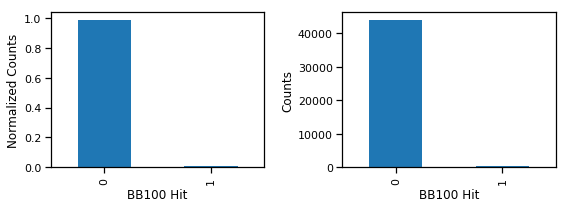

In [26]:
print('% of hits: {:5.3f}'.format(100*df.BBhot100.value_counts()[1]/df.BBhot100.value_counts()[0]))

plt.figure(1, figsize=(8,3))

plt.subplot(121)
df.BBhot100.value_counts(normalize=True).plot(kind='bar')
plt.ylabel('Normalized Counts')
plt.xlabel('BB100 Hit')

plt.subplot(122)
df.BBhot100.value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.xlabel('BB100 Hit')

plt.tight_layout()

Let's examine the dataset broken down by whether or not they appeared on the BB chart. Furthermore, we will break down the result by the mode of the song, which tells you if the modality is major (1) or minor (0). Major and minor modalities are typically associated with positive and negative ambience, respectively.

Hit songs tend to skew toward high energies regardless of the modality. The song tempo distribution is a little more ambiguous.

Text(0.5, 1.0, 'Hit/Major')

<Figure size 432x288 with 0 Axes>

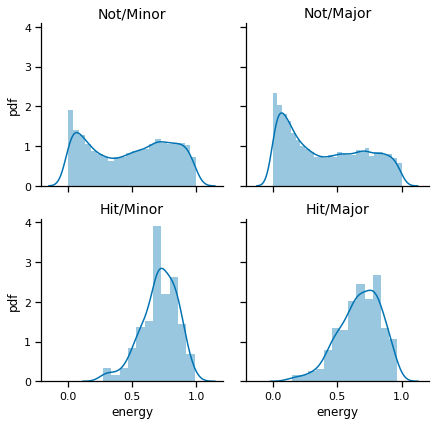

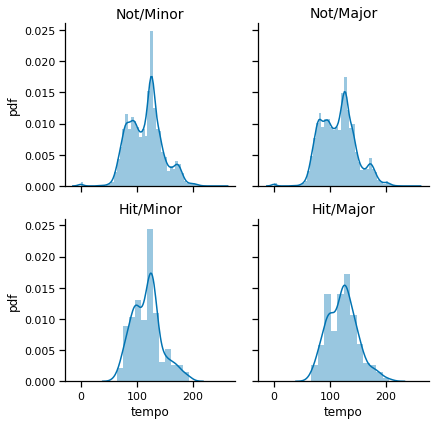

In [27]:
sns.set_palette("colorblind")

plt.figure(1)
g = sns.FacetGrid(df, col="mode", row="BBhot100")
g.map(sns.distplot, "energy").set_axis_labels("energy", "pdf")

axes = g.axes.flatten()
axes[0].set_title("Not/Minor", fontsize=14)
axes[1].set_title("Not/Major", fontsize=14)
axes[2].set_title("Hit/Minor", fontsize=14)
axes[3].set_title("Hit/Major", fontsize=14)

plt.figure(2)
g = sns.FacetGrid(df, col="mode", row="BBhot100")
g.map(sns.distplot, "tempo").set_axis_labels("tempo", "pdf")

axes = g.axes.flatten()
axes[0].set_title("Not/Minor", fontsize=14)
axes[1].set_title("Not/Major", fontsize=14)
axes[2].set_title("Hit/Minor", fontsize=14)
axes[3].set_title("Hit/Major", fontsize=14)

Before we proceed to examining the relationship between all audio features variables, let's look at the distribution of popscores (excluding 0 for non-hits), a metric that combines both its ranking on the BB100 chart and the durability of its popularity. There are several "mega-hits," those that sustained their high ranking on the chart for several weeks.

Text(0.5, 0, 'log(popscore)')

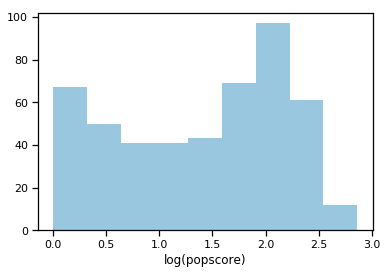

In [28]:
sns.set_palette("colorblind")
s = sns.distplot(np.log10(df[df.BBhot100 == 1]['popscore']), kde=False)
s.set_xlabel("log(popscore)")

These are the top 10 songs with the highest popscores. Based on a few spot checks, these are not all necessarily the mega-hits at #1 on the charts. For example, while ["Diamonds" by Rihanna](https://www.billboard.com/music/rihanna/chart-history/hot-100/song/759536) peaked at #1 (and stayed there for 3 weeks) but spent only 26 weeks overall on the chart, ["Thunder" by Imagine Dragons](https://www.billboard.com/music/imagine-dragons/chart-history/hot-100/song/1024087) peaked at only #4 but remained on the chart for a whopping 52 weeks.

In [29]:
df_0[df_0.BBhot100==1].sort_values('popscore', ascending=False).head(n=10)

artists                    titles  \
371                                         Rihanna                  Diamonds   
374                                         Rihanna  Only Girl (In The World)   
92               David Guetta Featuring Nicki Minaj                Turn Me On   
431                             The Black Eyed Peas      The Time (Dirty Bit)   
159           G-Eazy Featuring A$AP Rocky & Cardi B                  No Limit   
177                                 Imagine Dragons                   Thunder   
414                                    Taylor Swift  I Knew You Were Trouble.   
214                       KYLE Featuring Lil Yachty                      iSpy   
77   Chris Brown Featuring Lil Wayne & Busta Rhymes            Look At Me Now   
458                       Usher Featuring will.i.am                       OMG   

     year  BBhot100  popscore             artists_sid              tracks_sid  \
371  2012         1     726.0  5pKCCKE2ajJHZ9KAiaK11H  1z9kQ14XBSN0r2v6fx4IdG   
374  2010         1     662.0  5pKCCKE2ajJHZ9KAiaK11H  6jAsmDJI8iPhGWtS27kZ67   
92   2012         1     515.0  1Cs0zKBU1kc0i8ypK3B9ai  6JOlNkT0QdHeZB0wPbI9IR   
431  2010         1     485.0  1yxSLGMDHlW21z4YXirZDS  7vWFaMq63AwkFDhS2OAg5u   
159  2017         1     467.0  02kJSzxNuaWGqwubyUba0Z  2Xqd0wUttjueBfdcltADOv   
177  2017         1     454.0  53XhwfbYqKCa1cC15pYq2q  1zB4vmk8tFRmM9UULNzbLB   
414  2012         1     449.0  06HL4z0CvFAxyc27GXpf02  72jCZdH0Lhg93z6Z4hBjgj   
214  2017         1     445.0  4qBgvVog0wzW75IQ48mU7v  2EEeOnHehOozLq4aS0n6SL   
77   2011         1     434.0  7bXgB6jMjp9ATFy66eO08Z  7EKTo6rVJ3XSS7QTd6ep2j   
458  2010         1     394.0  23zg3TcAtWQy7J6upgbUnj  1bM50INir8voAkVoKuvEUI   

     danceability  energy  key  ...  mode  speechiness  acousticness  \
371         0.564   0.710   11  ...     0       0.0461       0.00125   
374         0.780   0.714   11  ...     0       0.0382       0.11900   
92          0.703   0.786    8  ...     1       0.0561       0.06660   
431         0.816   0.813    6  ...     0       0.0664       0.06620   
159         0.838   0.771    1  ...     1       0.2440       0.01170   
177         0.605   0.822    0  ...     1       0.0438       0.00671   
414         0.596   0.473    6  ...     1       0.0390       0.00563   
214         0.746   0.653    7  ...     1       0.2890       0.37800   
77          0.764   0.694   11  ...     0       0.1890       0.04390   
458         0.781   0.745    4  ...     0       0.0332       0.19800   

     instrumentalness  liveness  valence    tempo  duration_ms  \
371          0.000000    0.1090    0.393   91.972       225147   
374          0.000004    0.2170    0.666  125.924       235520   
92           0.000000    0.5530    0.475  127.954       199689   
431          0.000003    0.6020    0.436  127.979       307640   
159          0.000000    0.0853    0.405  175.957       245387   
177          0.134000    0.1470    0.288  167.997       187147   
414          0.000001    0.0430    0.648  154.228       217973   
214          0.000000    0.2290    0.672   75.016       253107   
77           0.000004    0.1800    0.581  146.075       223933   
458          0.000011    0.3600    0.326  129.998       269493   

     time_signature  BBhot100_history  
371               4                 1  
374               4                 1  
92                4                 1  
431               4                 1  
159               4                 1  
177               4                 1  
414               4                 1  
214               4                 1  
77                4                 1  
458               4                 1  

[10 rows x 21 columns]

Check the relationship between some variables. Perhaps unsurprisingly, hits tend to be highly danceable, high energy, loud, non-instrumental, non-live-recordings.

/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


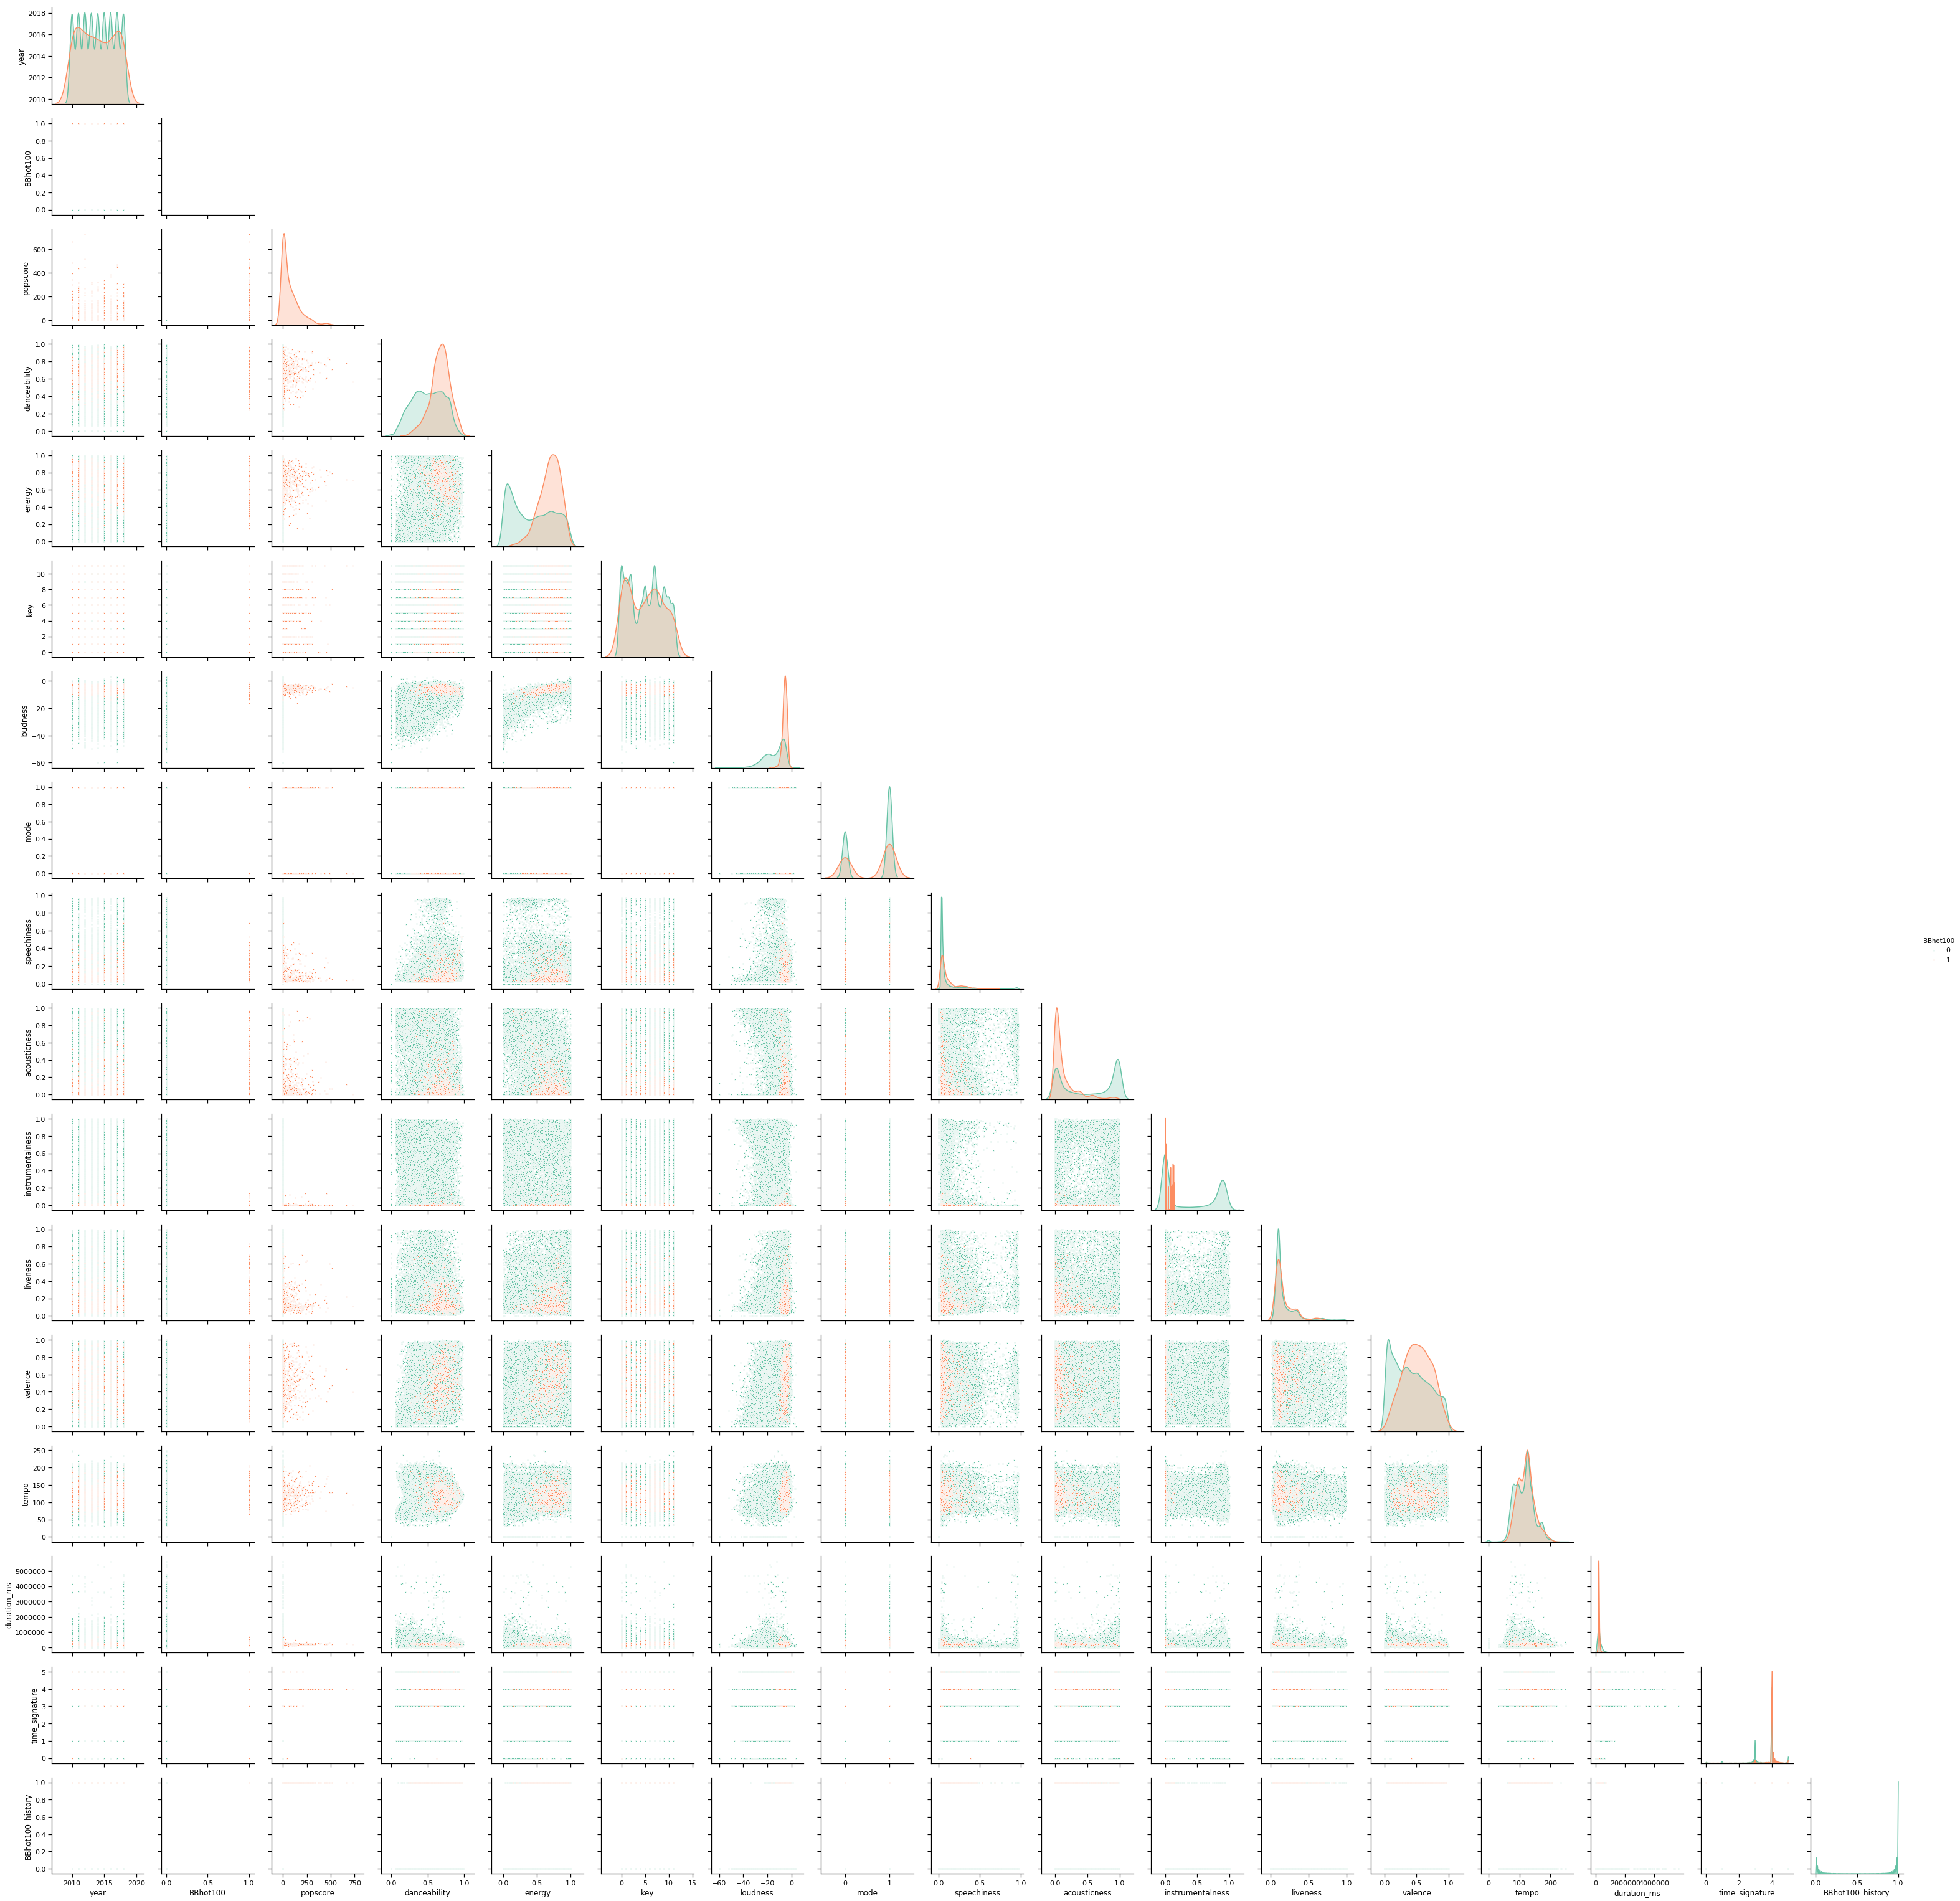

In [30]:
sns.set_palette("Set2")
s = sns.pairplot(df, hue='BBhot100', plot_kws={"s": 5})
for i, j in zip(*np.triu_indices_from(s.axes, 1)):
    s.axes[i, j].set_visible(False)

Here we check to see if there are any interesting trends with time. There appears to be some very weak evidence for hit songs trending away from extremely high-energy- and high-valence-ness (think Taio Cruz's "Dynamite" circa 2010) with time. Note that valenceness corresponds to "musical positiveness", where valence=1 evokes happy and/or cheerful thoughts whereas valence=0 evokes sad and/or angry feelings. Hit songs still tend to score strongly on the danceability spectrum. Early 2010s appears more strongly peaked at low popscores *and* skewed toward high popscores, which seems to suggest that, compared to late 2010s, the hits may have consisted of very few mega hits and less popular hits. 

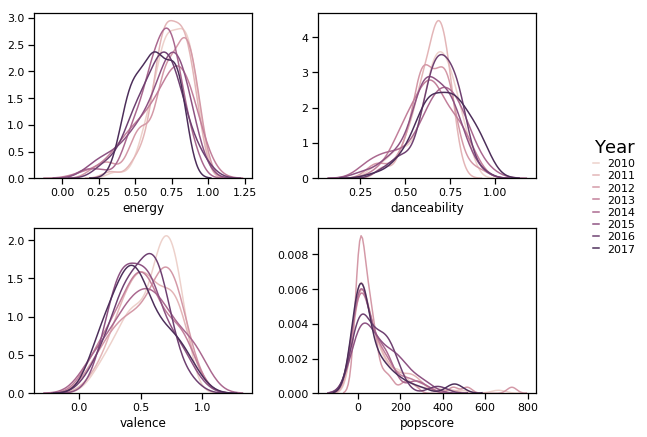

In [31]:
feat_list = ['energy', 'danceability', 'valence', 'popscore']
sns.set_palette(sns.cubehelix_palette(9))
plt.figure(1, figsize=(9,7))
for i_f, f in enumerate(feat_list):
    plt.subplot('22'+str(i_f+1))
    for y in range(2010, 2018):
        s = sns.kdeplot(df[(df.year == y)&(df.BBhot100 == 1)][f])
        s.set_xlabel(f)

    if i_f == 1:
        s.axes.legend(frameon=False, labelspacing=0.2, handlelength=0.5, bbox_to_anchor=(1.5, 0.3), title_fontsize=18)
        leg = s.axes.get_legend()
        leg.set_title('Year')
        new_labels = [str(x) for x in range(2010, 2018)]
        for t, l in zip(leg.texts, new_labels):
            t.set_text(l)

    else:
        leg = s.axes.get_legend().remove()

plt.subplots_adjust(wspace=0.3, hspace=0.3)

## Dealing with an Imbalanced Data Set

Our target label (1 or 0) is highly imbalanced, where BBhot100=True=1 constitutes only about 1% of the entire data set. Other examples of classification of imbalanced data include fraud detection and screening for rare diseases. 

There are several things we need to keep in mind when working with imbalanced data. The classifier will be biased towards the majority class (the non-hits in our example), and simple metrics such as accuracy are woefully insufficient when evaluating different models (i.e., a classifier that labels all songs as non-hits will be accurate 1% of the time in our example).

There are two approaches to dealing with an imbalanced data set. The first approach focuses on carefully choosing and modifying different classification algorithms to properly treat the imbalanced data sets. For example, sklearn allows the user to provide a ``class_weight`` parameter to classifiers such as SVC and LR. The second approach focuses on resampling the data prior to fitting models. We will test several resampling strategies, including very simple methods such as random over- and undersampling, as well as more sophisticated methods such as SMOTE (synthetic minority oversampling technique).

### Rescaling

First, ensure that all of the features are on a similar scale before we proceed with resampling and fitting.

In [3]:
for c in df.columns:
    print(c+':', min(df[c]), max(df[c]))

year: 2010 2018
BBhot100: 0 1
popscore: 0.0 726.0
danceability: 0.0 0.9890000000000001
energy: 0.0 1.0
key: 0 11
loudness: -60.0 3.383
mode: 0 1
speechiness: 0.0 0.97
acousticness: 0.0 0.996
instrumentalness: 0.0 1.0
liveness: 0.0 0.998
valence: 0.0 1.0
tempo: 0.0 249.019
duration_ms: 1393 5629030
time_signature: 0 5
BBhot100_history: 0 1


Subtract 2010 from the year so the values range from 0 to 8.

In [4]:
df['year'] = df['year'].apply(lambda x: x-2010)

Split the data frame into into train and test data sets and drop the target label. Also drop the popscore since it essentially encodes BBhot100 as well.

In [5]:
df_orig_train, df_final_test = model_selection.train_test_split(df, test_size=0.3, stratify=df.BBhot100)

Scale the values to between 0 and 1. We rescale the features separately since we want to retain the integer type for some of our features for resampling later.

In [6]:
scale_ind = [np.ravel(np.where(df_orig_train.columns.values == x))[0] for x in ['loudness', 'tempo', 'duration_ms']]

sc = preprocessing.RobustScaler()
sc.fit(df_orig_train.iloc[:,scale_ind])

df_orig_train_sc_1 = pd.DataFrame(sc.transform(df_orig_train.iloc[:,scale_ind]), \
                                index=df_orig_train.index, columns = df_orig_train.iloc[:,scale_ind].columns)
df_final_test_sc_1 = pd.DataFrame(sc.transform(df_final_test.iloc[:,scale_ind]), \
                                index=df_final_test.index, columns = df_final_test.iloc[:,scale_ind].columns)

Save for later use.

In [7]:
#with open("scaler.pickle", "wb") as handle:
#    pickle.dump(sc, handle)

Combine with the other columns.

In [8]:
noscale_ind = [np.ravel(np.where(df_orig_train.columns.values == x))[0] for x in df_orig_train.columns.values if x not in ['loudness', 'tempo', 'duration_ms'] ]

df_orig_train_sc = pd.concat([df_orig_train.iloc[:,noscale_ind], df_orig_train_sc_1], axis=1)
df_final_test_sc = pd.concat([df_final_test.iloc[:,noscale_ind], df_final_test_sc_1], axis=1)

Separate features and label.

In [9]:
orig_train_y = df_orig_train_sc.BBhot100.copy()
orig_train_X = df_orig_train_sc.drop(columns=['BBhot100', 'popscore'])
final_test_y = df_final_test_sc.BBhot100.copy()
final_test_X = df_final_test_sc.drop(columns=['BBhot100', 'popscore'])

Some checks before proceeding.

In [10]:
orig_train_X.describe()

year  danceability        energy          key          mode  \
count  31152.000000  31152.000000  31152.000000  31152.00000  31152.000000   
mean       4.000706      0.507687      0.437595      5.19055      0.662333   
std        2.582478      0.210070      0.307112      3.57875      0.472922   
min        0.000000      0.000000      0.000000      0.00000      0.000000   
25%        2.000000      0.342000      0.140000      2.00000      0.000000   
50%        4.000000      0.513000      0.422000      5.00000      1.000000   
75%        6.000000      0.683000      0.713000      8.00000      1.000000   
max        8.000000      0.989000      1.000000     11.00000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  31152.000000  31152.000000      31152.000000  31152.000000   
mean       0.100515      0.530003          0.382448      0.188275   
std        0.149022      0.408248          0.409159      0.166691   
min        0.000000      0.000000          0.000000      0.000000   
25%        0.038000      0.063300          0.000004      0.093800   
50%        0.046900      0.606000          0.111000      0.120000   
75%        0.079400      0.960000          0.863000      0.220000   
max        0.968000      0.996000          1.000000      0.998000   

            valence  time_signature  BBhot100_history      loudness  \
count  31152.000000    31152.000000      31152.000000  31152.000000   
mean       0.421846        3.813078          0.022631     -0.169189   
std        0.276955        0.600861          0.148726      0.638393   
min        0.000000        0.000000          0.000000     -3.847427   
25%        0.174000        4.000000          0.000000     -0.638664   
50%        0.394000        4.000000          0.000000      0.000000   
75%        0.643000        4.000000          0.000000      0.361336   
max        1.000000        5.000000          1.000000      1.185801   

              tempo   duration_ms  
count  31152.000000  31152.000000  
mean      -0.045522      0.265798  
std        0.716762      1.421146  
min       -2.732428     -1.639494  
25%       -0.610865     -0.401603  
50%        0.000000      0.000000  
75%        0.389135      0.598397  
max        3.082885     37.465390

/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


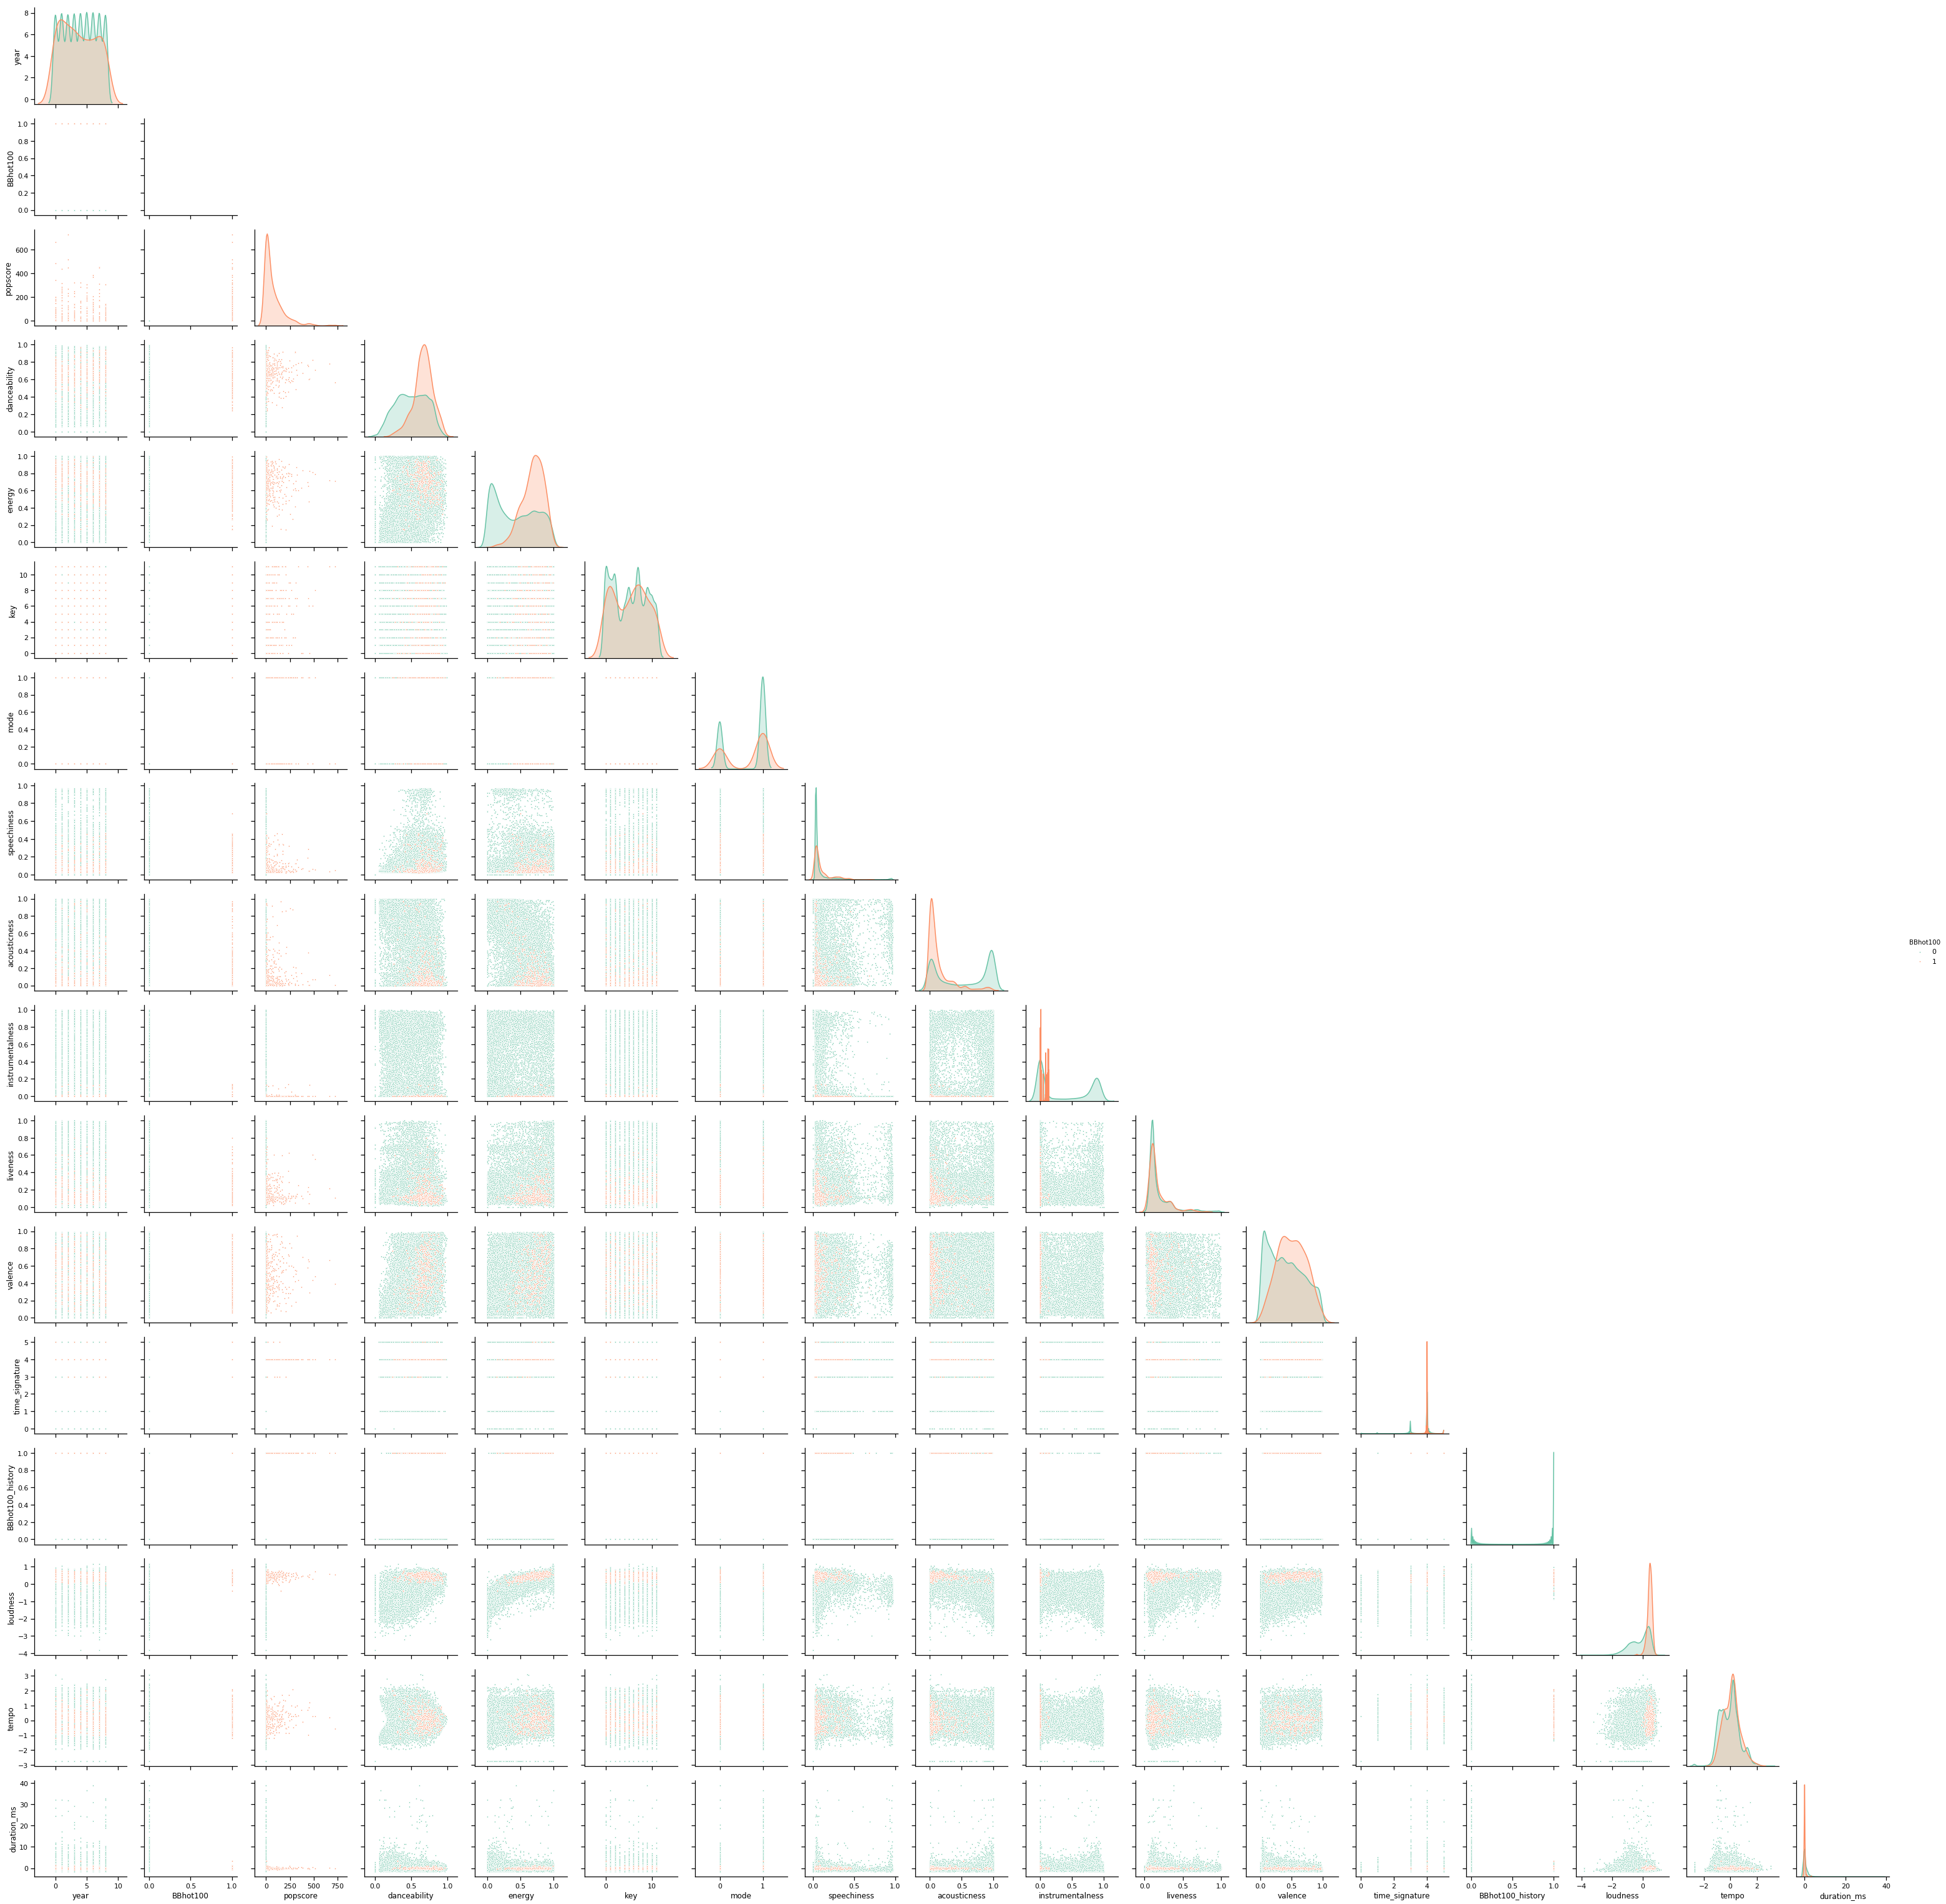

In [43]:
sns.set_palette("Set2")

s = sns.pairplot(df_orig_train_sc, vars=df_orig_train_sc, hue='BBhot100', plot_kws={"s": 5})
for i, j in zip(*np.triu_indices_from(s.axes, 1)):
    s.axes[i, j].set_visible(False)

### Naive Approach

Let's go ahead and fit our data with a random forest classifier and examine the performance metrics, though we should keep in mind that the results may be different depending on our choice of the classifier.

Just to remind ourselves...

$$\rm Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$
$$\rm Precision = \frac{TP}{TP+FP}$$
$$\rm Recall = \frac{TP}{TP+FN}$$

In [46]:
stkfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

acc_list = []
pre_list = []
rec_list = []
for train_ind, test_ind in stkfold.split(orig_train_X, orig_train_y):
    train_X, train_y, test_X, test_y = orig_train_X.iloc[train_ind], orig_train_y.iloc[train_ind], orig_train_X.iloc[test_ind], orig_train_y.iloc[test_ind]
    clf = ensemble.RandomForestClassifier(n_estimators=100)
    clf.fit(train_X, train_y)
    pred_y = clf.predict(test_X)

    acc_list.append(metrics.accuracy_score(test_y, pred_y))
    pre_list.append(metrics.precision_score(test_y, pred_y))
    rec_list.append(metrics.recall_score(test_y, pred_y))

print('Model accuracy: {:5.3f}'.format(np.mean(acc_list)))
print('If we always guess 0: {:5.3f}'.format(sum((test_y == 0)*1.0)*1.0/len(test_y)))

print('Precision: {:5.3f}'.format(np.mean(pre_list)))
print('Recall: {:5.3f}'.format(np.mean(rec_list)))

Model accuracy: 0.993
If we always guess 0: 0.989
Precision: 0.702
Recall: 0.549


### Resampling

We will try resample the data to try to reduce the imbalance. When we perform cross-validation, we have to resample *during* not *before*. For example, if we oversample the minority class before performing CV, information can "leak" from the training set into the validation set, which would result in overfitting.

In [47]:
stkfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

def resample_test(sampler, clf, **kwargs):
    
    rat = []
    acc = []
    pre = []
    rec = []
    for i_r, ratio in enumerate(np.arange(0.1, 1.1, 0.1)):
        
        acc0 = []
        pre0 = []
        rec0 = []
        for train_ind, test_ind in stkfold.split(orig_train_X, orig_train_y):
            
            train_X, train_y, test_X, test_y = orig_train_X.iloc[train_ind], orig_train_y.iloc[train_ind], orig_train_X.iloc[test_ind], orig_train_y.iloc[test_ind]
            res = sampler(sampling_strategy=ratio, **kwargs)            
            res_train_X, res_train_y = res.fit_resample(train_X, train_y)
            
            #this should have no effect on resampling algorithms that 
            #don't produce floats where there are meant to be integers.
            #not entirely sure if this is the best method.
            cat_feat_ind = np.where(orig_train_X.dtypes == 'int')[0].tolist()
            res_train_X[:, cat_feat_ind] = np.rint(res_train_X[:, cat_feat_ind])

            clf.fit(res_train_X, res_train_y)
            pred_y_rs = clf.predict(test_X)
            
            acc0.append(metrics.accuracy_score(test_y, pred_y_rs))
            pre0.append(metrics.precision_score(test_y, pred_y_rs))
            rec0.append(metrics.recall_score(test_y, pred_y_rs))
       
        rat.append(ratio)
        acc.append(np.mean(acc0))
        pre.append(np.mean(pre0))
        rec.append(np.mean(rec0))
    
    plt.figure(1, figsize=(7,5))
    plt.xlabel(r'$N_{\rm min}/N_{\rm maj}$')
    plt.plot(rat, acc, label='Accuracy', linewidth=2.5)
    plt.plot(rat, pre, label='Precision', linewidth=2.5)
    plt.plot(rat, rec, label='Recall', linewidth=2.5)
    plt.ylim(0.45, 1.05)
    leg = plt.legend(loc=4, handlelength=0.5, fontsize=14)
    leg.draw_frame(False)
    
    return rat, acc, pre, rec

#### Random Undersampling

We use the simple undersampling strategy wherein we decrease the number of samples in the majority class (non-hits) to bring the ratio of majority to minority class to a number closer to 1 instead of e.g., 100. We choose to resample without replacement to avoid ending up with unnecessary duplicates in the final resampled data set. 

A major disadvantage is the potential loss of information, as we are discarding a large portion of the samples.

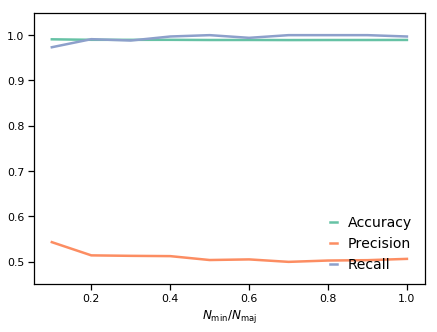

In [48]:
us = under_sampling.RandomUnderSampler
clf = ensemble.RandomForestClassifier(n_estimators=50)
rat, acc, pre, rec = resample_test(us, clf)

#### Random Oversampling

We use the simple oversampling strategy wherein we boost the number of samples in the minority class (BB100 hits) to bring the ratio of majority to minority class to a number closer to 1 instead of e.g., 100. 

We no longer have loss of information, but a new disadvantage is the potential to overfit since we are simply duplicating the minority class samples.

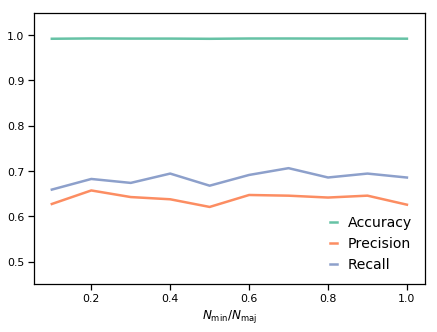

In [49]:
os = over_sampling.RandomOverSampler
clf = ensemble.RandomForestClassifier(n_estimators=50)
rat, acc, pre, rec = resample_test(os, clf)

#### SMOTE (Synthetic Minority Oversampling TEchnique)

We use a more sophisticated strategy to boost the number of samples in the minority class. Rather than simply copying repeatedly the few existing minority class sample, we generate new data that are representative of the minority class. From the existing minority sample, we choose k number of neighbors from which we synthesize N new data that lie somewhere between these points (i.e., interpolation).

Since SMOTE introduces some randomness to the newly sampled minority class, this helps to combat overfitting.

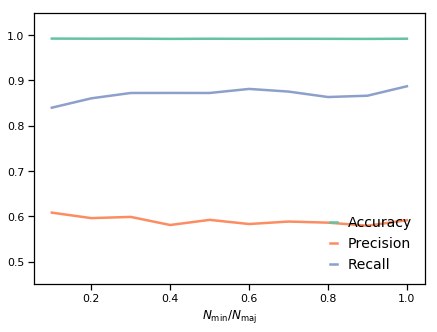

In [50]:
#here we use a variant that allows for both continuous and categorical data
cat_feat_ind = np.where(orig_train_X.dtypes == 'int')[0].tolist()

smt = over_sampling.SMOTENC
clf = ensemble.RandomForestClassifier(n_estimators=50)
rat, acc, pre, rec = resample_test(smt, clf, categorical_features=cat_feat_ind)

A couple of SMOTE variations. There is no non-continuous variable support for these in imblearn. To ensure integer types for several features, we rounded them to the nearest integer after the resampling. Not entirely sure if this is safe to do.

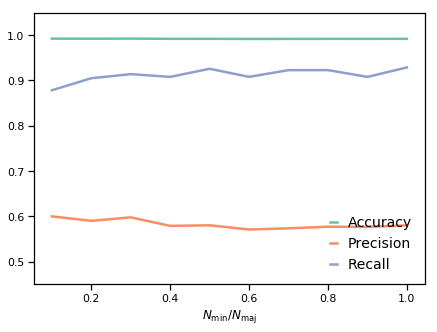

In [51]:
smt = over_sampling.SVMSMOTE
clf = ensemble.RandomForestClassifier(n_estimators=50)
rat, acc, pre, rec = resample_test(smt, clf)

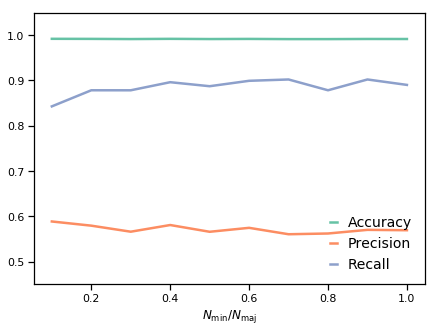

In [52]:
smt = over_sampling.BorderlineSMOTE
clf = ensemble.RandomForestClassifier(n_estimators=50)
rat, acc, pre, rec = resample_test(smt, clf, kind='borderline-2')

#### ADASYN (ADAptive SYNthetic) 

We will check one more oversampling strategy which is a close cousin of SMOTE, with one importance difference. ADASYN uses the density distribution of the minority class to automatically choose the number of new synthetic samples created per existing minority sample. The overall effect is that ADASYN generates more synthetic samples for minority class samples that are difficult to learn, e.g., near the decision boundary. In comparison, in SMOTE, equal numbers of synthetic samples are created for each existing, original minority sample).

*There is no non-continuous variable support for ADASYN in imblearn, so the same rounding trick was applied here.

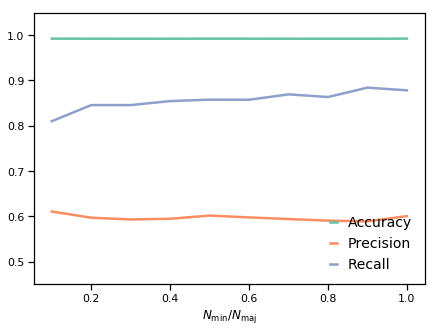

In [53]:
smt = over_sampling.ADASYN
clf = ensemble.RandomForestClassifier(n_estimators=50)
rat, acc, pre, rec = resample_test(smt, clf)

The resampling method we end up choosing depends on our priorities. We see some trade-off between precision and recall, so the question is: do we want to maximize precision or recall? High precision and low recall means we are prioritizing our ability to correctly predict songs that really are hits, even if it means we might let some hits slip through the cracks due to our conservative approach. Low precision and high recall means we will generally predict more songs to be hits even if some of those end up to be inaccurate predictions. 

This type of precision-recall trade-off must be carefully thought through depending on the context: with fatal disease screening, doctors would probably err on the side of low precision and high recall since they would want to make sure that they catch more positive results even if some of those do end up being false positives.

## Training the Model

We will test several classification algorithms on now balanced data. SMOTE (and its variations) and ADASYN generally perform comparably well. We will proceed with SMOTENC as it supports categorical features. Since the performance seems pretty insensitive to the ratio, we will just pick 0.5.

We use nested CV to optimize the hyperparameters and evaluate the performance of the model.

- Gaussian Naive Bayes
- Logistic Regression
- Support Vector Classifier
- Random Forest Classifier
- XGBoost
- Adaboost

NB is much faster than the other algorithms tested, for comparable performance. Unlike the other algorithms, NB doesn't have tunable hyperparameters that can further improve its performance. A good alternative is probably RFC as it is relatively fast and performs well, *and* its performance may improve, however marginally, with some hyperparameter tuning.

### Trying out several algorithms

In [54]:
num_feat = len(orig_train_X.columns)

#sometimes the recall/precision score are 0 and f1 is undefined
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

model_list = {"NB": naive_bayes.GaussianNB(), "XGB":xgboost.XGBClassifier(),\
              "AB": ensemble.AdaBoostClassifier(), "RFC": ensemble.RandomForestClassifier(),\
              "SVC":svm.SVC(probability=True), "LR":linear_model.LogisticRegression()}

params = {"NB":{'var_smoothing': pow(10,stats.uniform.rvs(loc=-11,scale=7,size=1000))},\
          "LR":{'C': pow(10,stats.uniform.rvs(loc=-3,scale=3.5,size=1000)), 'penalty': ['l1', 'l2'],\
                'solver':['saga'], 'max_iter': [5000]},\
          "SVC":{'C': pow(10,stats.uniform.rvs(loc=-3,scale=3.5,size=1000)), 'kernel': ['linear','rbf'], \
                 'gamma': pow(10,stats.uniform.rvs(loc=-2,scale=2.5,size=1000))},\
          "RFC":{"n_estimators": stats.randint(50,200), "max_features": stats.randint(2, num_feat), \
                 "max_depth": stats.randint(2,8), "min_samples_split": stats.randint(2,15), \
                 "min_samples_leaf": stats.randint(2,8)},\
          "XGB":{"max_depth": stats.randint(2,8), "learning_rate": pow(10,stats.uniform.rvs(loc=-2,scale=2,size=1000)),\
                 "n_estimators": stats.randint(50,200), "reg_lambda": pow(10,stats.uniform.rvs(loc=-2,scale=2.5,size=1000)), \
                 "reg_alpha": pow(10,stats.uniform.rvs(loc=-2,scale=2.5,size=1000)), \
                 "min_child_weight": stats.uniform(loc=0,scale=2)},\
          "AB":{"n_estimators": stats.randint(50,200), "learning_rate": pow(10,stats.uniform.rvs(loc=-2,scale=2.5,size=1000))}}
                 
for i_m, m in enumerate(model_list.keys()):
    
    outer_cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    inner_cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    
    print('-'*40)
    print("{:-^40}".format(m))
    print('-'*40)
          
    #inner CV to optimize, resampling has to be done during this inner loop
    cat_feat_ind = np.where(orig_train_X.dtypes == 'int')[0].tolist()
    res = over_sampling.SMOTENC(cat_feat_ind, sampling_strategy=0.5)
    #only iterates 10 times, which is not many but we will keep this low to make the computational time manageable
    clf = model_selection.RandomizedSearchCV(model_list[m], params[m], refit=True, cv=inner_cv, scoring='neg_log_loss', verbose=True)
    pipe = imb_make_pipeline(res, clf)

    #outer CV to compute the score. 
    #this syntax passes the "training fold" from this 5-fold CV to RandomizedSearchCV
    scoring = {'acc': 'accuracy', 'pre': 'precision', 'rec': 'recall', 'f1': 'f1'}
    scores = model_selection.cross_validate(pipe, orig_train_X.values, orig_train_y.values, cv=outer_cv, scoring=scoring, return_train_score=False)

    print('{:<20}'.format('Training Time:')+'{:5.3f}'.format(np.mean(scores['fit_time']))+'+/-'+'{:5.3f}'.format(np.std(scores['fit_time'])))
    print('{:<20}'.format('Testing Time:')+'{:5.3f}'.format(np.mean(scores['score_time']))+'+/-'+'{:5.3f}'.format(np.std(scores['score_time'])))
    print('{:<20}'.format('Accuracy:')+'{:5.3f}'.format(np.mean(scores['test_acc']))+'+/-'+'{:5.3f}'.format(np.std(scores['test_acc'])))
    print('{:<20}'.format('Precision:')+'{:5.3f}'.format(np.mean(scores['test_pre']))+'+/-'+'{:5.3f}'.format(np.std(scores['test_pre'])))
    print('{:<20}'.format('Recall:')+'{:5.3f}'.format(np.mean(scores['test_rec']))+'+/-'+'{:5.3f}'.format(np.std(scores['test_rec'])))
    print('{:<20}'.format('F1 Score:')+'{:5.3f}'.format(np.mean(scores['test_f1']))+'+/-'+'{:5.3f}'.format(np.std(scores['test_f1'])))
          

----------------------------------------
-------------------NB-------------------
----------------------------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.2s finished


Training Time:      18.091+/-0.108
Testing Time:       0.009+/-0.001
Accuracy:           0.991+/-0.001
Precision:          0.539+/-0.037
Recall:             0.962+/-0.020
F1 Score:           0.690+/-0.025
----------------------------------------
------------------XGB-------------------
----------------------------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.4min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1817: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/

Training Time:      251.703+/-23.123
Testing Time:       0.095+/-0.023
Accuracy:           0.992+/-0.000
Precision:          0.604+/-0.016
Recall:             0.857+/-0.043
F1 Score:           0.709+/-0.024
----------------------------------------
-------------------AB-------------------
----------------------------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.5min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.6min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.2min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.7min finished


Training Time:      261.071+/-62.106
Testing Time:       0.186+/-0.051
Accuracy:           0.989+/-0.001
Precision:          0.497+/-0.030
Recall:             1.000+/-0.000
F1 Score:           0.664+/-0.027
----------------------------------------
------------------RFC-------------------
----------------------------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.1min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.7min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.4min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.1min finished


Training Time:      219.957+/-15.260
Testing Time:       0.122+/-0.037
Accuracy:           0.991+/-0.001
Precision:          0.550+/-0.020
Recall:             0.970+/-0.016
F1 Score:           0.702+/-0.016
----------------------------------------
------------------SVC-------------------
----------------------------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 61.4min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 46.3min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 64.1min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 17.5min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 138.4min finished


Training Time:      3992.743+/-2389.103
Testing Time:       1.265+/-0.930
Accuracy:           0.990+/-0.001
Precision:          0.514+/-0.026
Recall:             0.971+/-0.045
F1 Score:           0.671+/-0.021
----------------------------------------
-------------------LR-------------------
----------------------------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.7min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 46.6min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.6min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  9.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.7min finished


Training Time:      1383.018+/-1025.165
Testing Time:       0.009+/-0.007
Accuracy:           0.990+/-0.001
Precision:          0.524+/-0.020
Recall:             0.994+/-0.007
F1 Score:           0.686+/-0.019


### Hyperparameter Tuning 

Now we tune our model on the entire training set, then test on our holdout set. Rather than the brute-force grid search or even the random search, we will use bayesian optimization to obtain the best hyperparameters. In particular, we will use this package that uses gaussian processes to estimate/represent our objective function (the function we are trying to optimize that outputs a score, such as F1, with hyperparameters as inputs).

A gaussian process is a non-parametric function wherein the random variables obey multivariate normal distribution. It is frequently described as "a distribution over functions," or an ordinary multivariate normal distribution extended to infinite variables. It's a very powerful method for modeling complex functions $and$ obtaining uncertainties.

We're using the [bayes_opt](https://github.com/fmfn/BayesianOptimization) package, a general Python implementation of optimization with GP. Handling discrete parameters such as integers is still not properly supported. The development of this feature is still pending: in the mean time, we're using the [workaround](https://github.com/fmfn/BayesianOptimization/blob/master/examples/sklearn_example.py) suggested by the developer, though it's not 100% clear if it is effective. We might need to move onto a different optimizer. 

In [39]:
def rfc_cv(n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, data, targets):
    """
    Compute the CV score for the given set of hyperparameters. 
    """
    
    assert type(n_estimators) == int
    assert type(max_depth) == int
    assert type(min_samples_split) == int
    assert type(min_samples_leaf) == int
    
    clf = ensemble.RandomForestClassifier(n_estimators=n_estimators, \
                                          max_features=max_features, max_depth=max_depth,\
                                          min_samples_split=min_samples_split,\
                                          min_samples_leaf=min_samples_leaf)
    
    #stratified Kfold with k=5
    cv_score = model_selection.cross_validate(clf, data, targets, cv=5, scoring='neg_log_loss', return_train_score=False)['test_score'].mean()
    
    return cv_score

def optimize_rfc(data, targets):
        
    def rfc_crossval(n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf):
        """
        Define the function to be optimized. 
        Wrapper for the function that computes the CV score. 
        Additionally enforces integer values for some parameters.
        """
        return rfc_cv(n_estimators=int(n_estimators), \
                      max_features=max(min(0.99,max_features),0.01),\
                      max_depth=int(max_depth),\
                      min_samples_split=int(min_samples_split),\
                      min_samples_leaf=int(min_samples_leaf),\
                      data=data, targets=targets)
    
    optimizer = BayesianOptimization(f=rfc_crossval, verbose=2, \
                                     pbounds={"n_estimators":(50,300), \
                                              "max_features":(0.4,0.99),\
                                              "max_depth":(20,30),\
                                              "min_samples_split":(2,20),\
                                              "min_samples_leaf":(2,20)})
    optimizer.maximize(init_points=10, n_iter=100, acq='ei', xi=0.0, alpha=1e-6)
    
    return(optimizer)

In [40]:
cat_feat_ind = np.where(orig_train_X.dtypes == 'int')[0].tolist()
res = over_sampling.SMOTENC(cat_feat_ind, sampling_strategy=0.5)
res_train_X, res_train_y = res.fit_resample(orig_train_X, orig_train_y)

opt_results = optimize_rfc(res_train_X, res_train_y)
print(opt_results.max['params'])

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -0.02428  |  26.84    |  0.6902   |  18.9     |  12.97    |  207.1    |
|  2        | -0.01822  |  29.95    |  0.8151   |  2.591    |  10.19    |  250.7    |
|  3        | -0.02375  |  24.1     |  0.465    |  15.48    |  7.103    |  154.1    |
|  4        | -0.01964  |  21.07    |  0.6427   |  5.125    |  3.618    |  283.2    |
|  5        | -0.02233  |  20.93    |  0.5797   |  11.99    |  18.4     |  99.81    |
|  6        | -0.0241   |  25.78    |  0.7755   |  17.23    |  10.29    |  232.0    |
|  7        | -0.01875  |  29.86    |  0.6413   |  4.345    |  12.63    |  256.5    |
|  8        | -0.02414  |  28.7     |  0.9364   |  16.56    |  12.66    |  130.7    |
|  9        | -0.0223   |  24.77    |  0.6365   |  12.55    |  17.49    |  268.4    |
|  10       | -0.01879  |  28.46    |  0.9261   |  3.7

|  58       | -0.01672  |  29.58    |  0.4422   |  2.215    |  2.756    |  160.3    |
|  59       | -0.01649  |  29.94    |  0.4893   |  2.149    |  3.226    |  294.0    |
|  60       | -0.01623  |  29.69    |  0.4108   |  2.204    |  2.104    |  269.6    |
|  61       | -0.01659  |  29.06    |  0.4059   |  2.502    |  2.76     |  117.7    |
|  62       | -0.0166   |  28.99    |  0.4222   |  2.405    |  2.442    |  150.0    |
|  63       | -0.01633  |  29.99    |  0.4232   |  2.352    |  2.956    |  148.1    |
|  64       | -0.01684  |  29.45    |  0.4685   |  2.302    |  3.118    |  116.8    |
|  65       | -0.0165   |  29.96    |  0.4437   |  2.146    |  5.263    |  130.1    |
|  66       | -0.01655  |  29.73    |  0.5843   |  2.62     |  2.054    |  298.6    |
|  67       | -0.01621  |  29.55    |  0.4224   |  2.605    |  2.141    |  297.3    |
|  68       | -0.01657  |  29.47    |  0.43     |  2.029    |  3.476    |  138.7    |
|  69       | -0.01703  |  28.31    |  0.5387   |  2.1

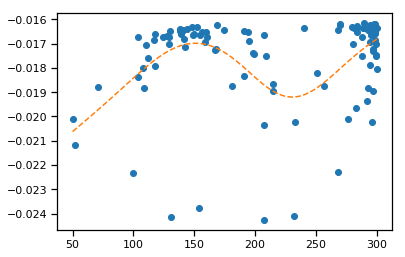

In [102]:
X = np.array([res["params"]["n_estimators"] for res in opt_results.res])
Y = np.array([res["target"] for res in opt_results.res])

opt_results._gp.fit(X.reshape(-1,1), Y.reshape(-1,1))
grid = np.linspace(50, 300, 100).reshape(-1,1)
mu, sigma = opt_results._gp.predict(grid, return_std=True)

plt.plot(X.flatten(), Y, 'o')
plt.plot(grid, mu, '--')

In [94]:
tuned_params = {'max_depth': 29, 'max_features': 0.4123, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 289}
tuned_clf = ensemble.RandomForestClassifier(**tuned_params)
tuned_clf.fit(res_train_X, res_train_y)
pred_y = tuned_clf.predict(final_test_X)

In [96]:
save_clf = False
save_file = 'hitornot_rfc_tuned_0326.joblib'
if save_clf:
    #if the file exists already, throw an error to prevent overwriting
    assert not os.path.isfile(save_file)
    dump(tuned_clf, save_file) 
else:
    clf = load(save_file) 
    pred_y = clf.predict(final_test_X)

### Examine the Results

In [95]:
print(metrics.classification_report(final_test_y, pred_y, digits=3, output_dict=False))

              precision    recall  f1-score   support

           0      0.999     0.993     0.996     13208
           1      0.575     0.875     0.694       144

   micro avg      0.992     0.992     0.992     13352
   macro avg      0.787     0.934     0.845     13352
weighted avg      0.994     0.992     0.993     13352



We score higher on the recall than precision, meaning we're less likely to miss actual hits, but we misclassify non-hits as hits about half the time. 

Text(0.5, 12.5, 'Predicted Hit')

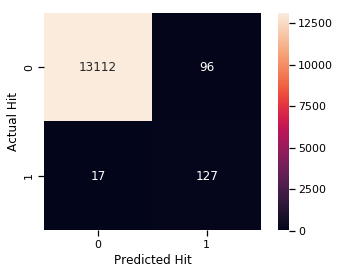

In [98]:
cm = metrics.confusion_matrix(final_test_y, pred_y)
ax = sns.heatmap(cm, square=True, annot=True, fmt="d")
ax.set_ylabel('Actual Hit')
ax.set_xlabel('Predicted Hit')

Examine the TP, FP, FN results to see if there's anything unusual about their features.

TP (blue) and FP (orange) have strongly overlapping distributions, which is not surprising: they share very similar characteristics and thus it is difficult to distinguish between the two categories.

FP (green) overlaps with TP and FP in many ways, but also show several interesting differences. These FPs tend to score lower on the danceability, energy, and valence scores, and are more widely distributed in acousticness scores (skewed right). The distribution of track duration is also wider, with long tails in both directions.

/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


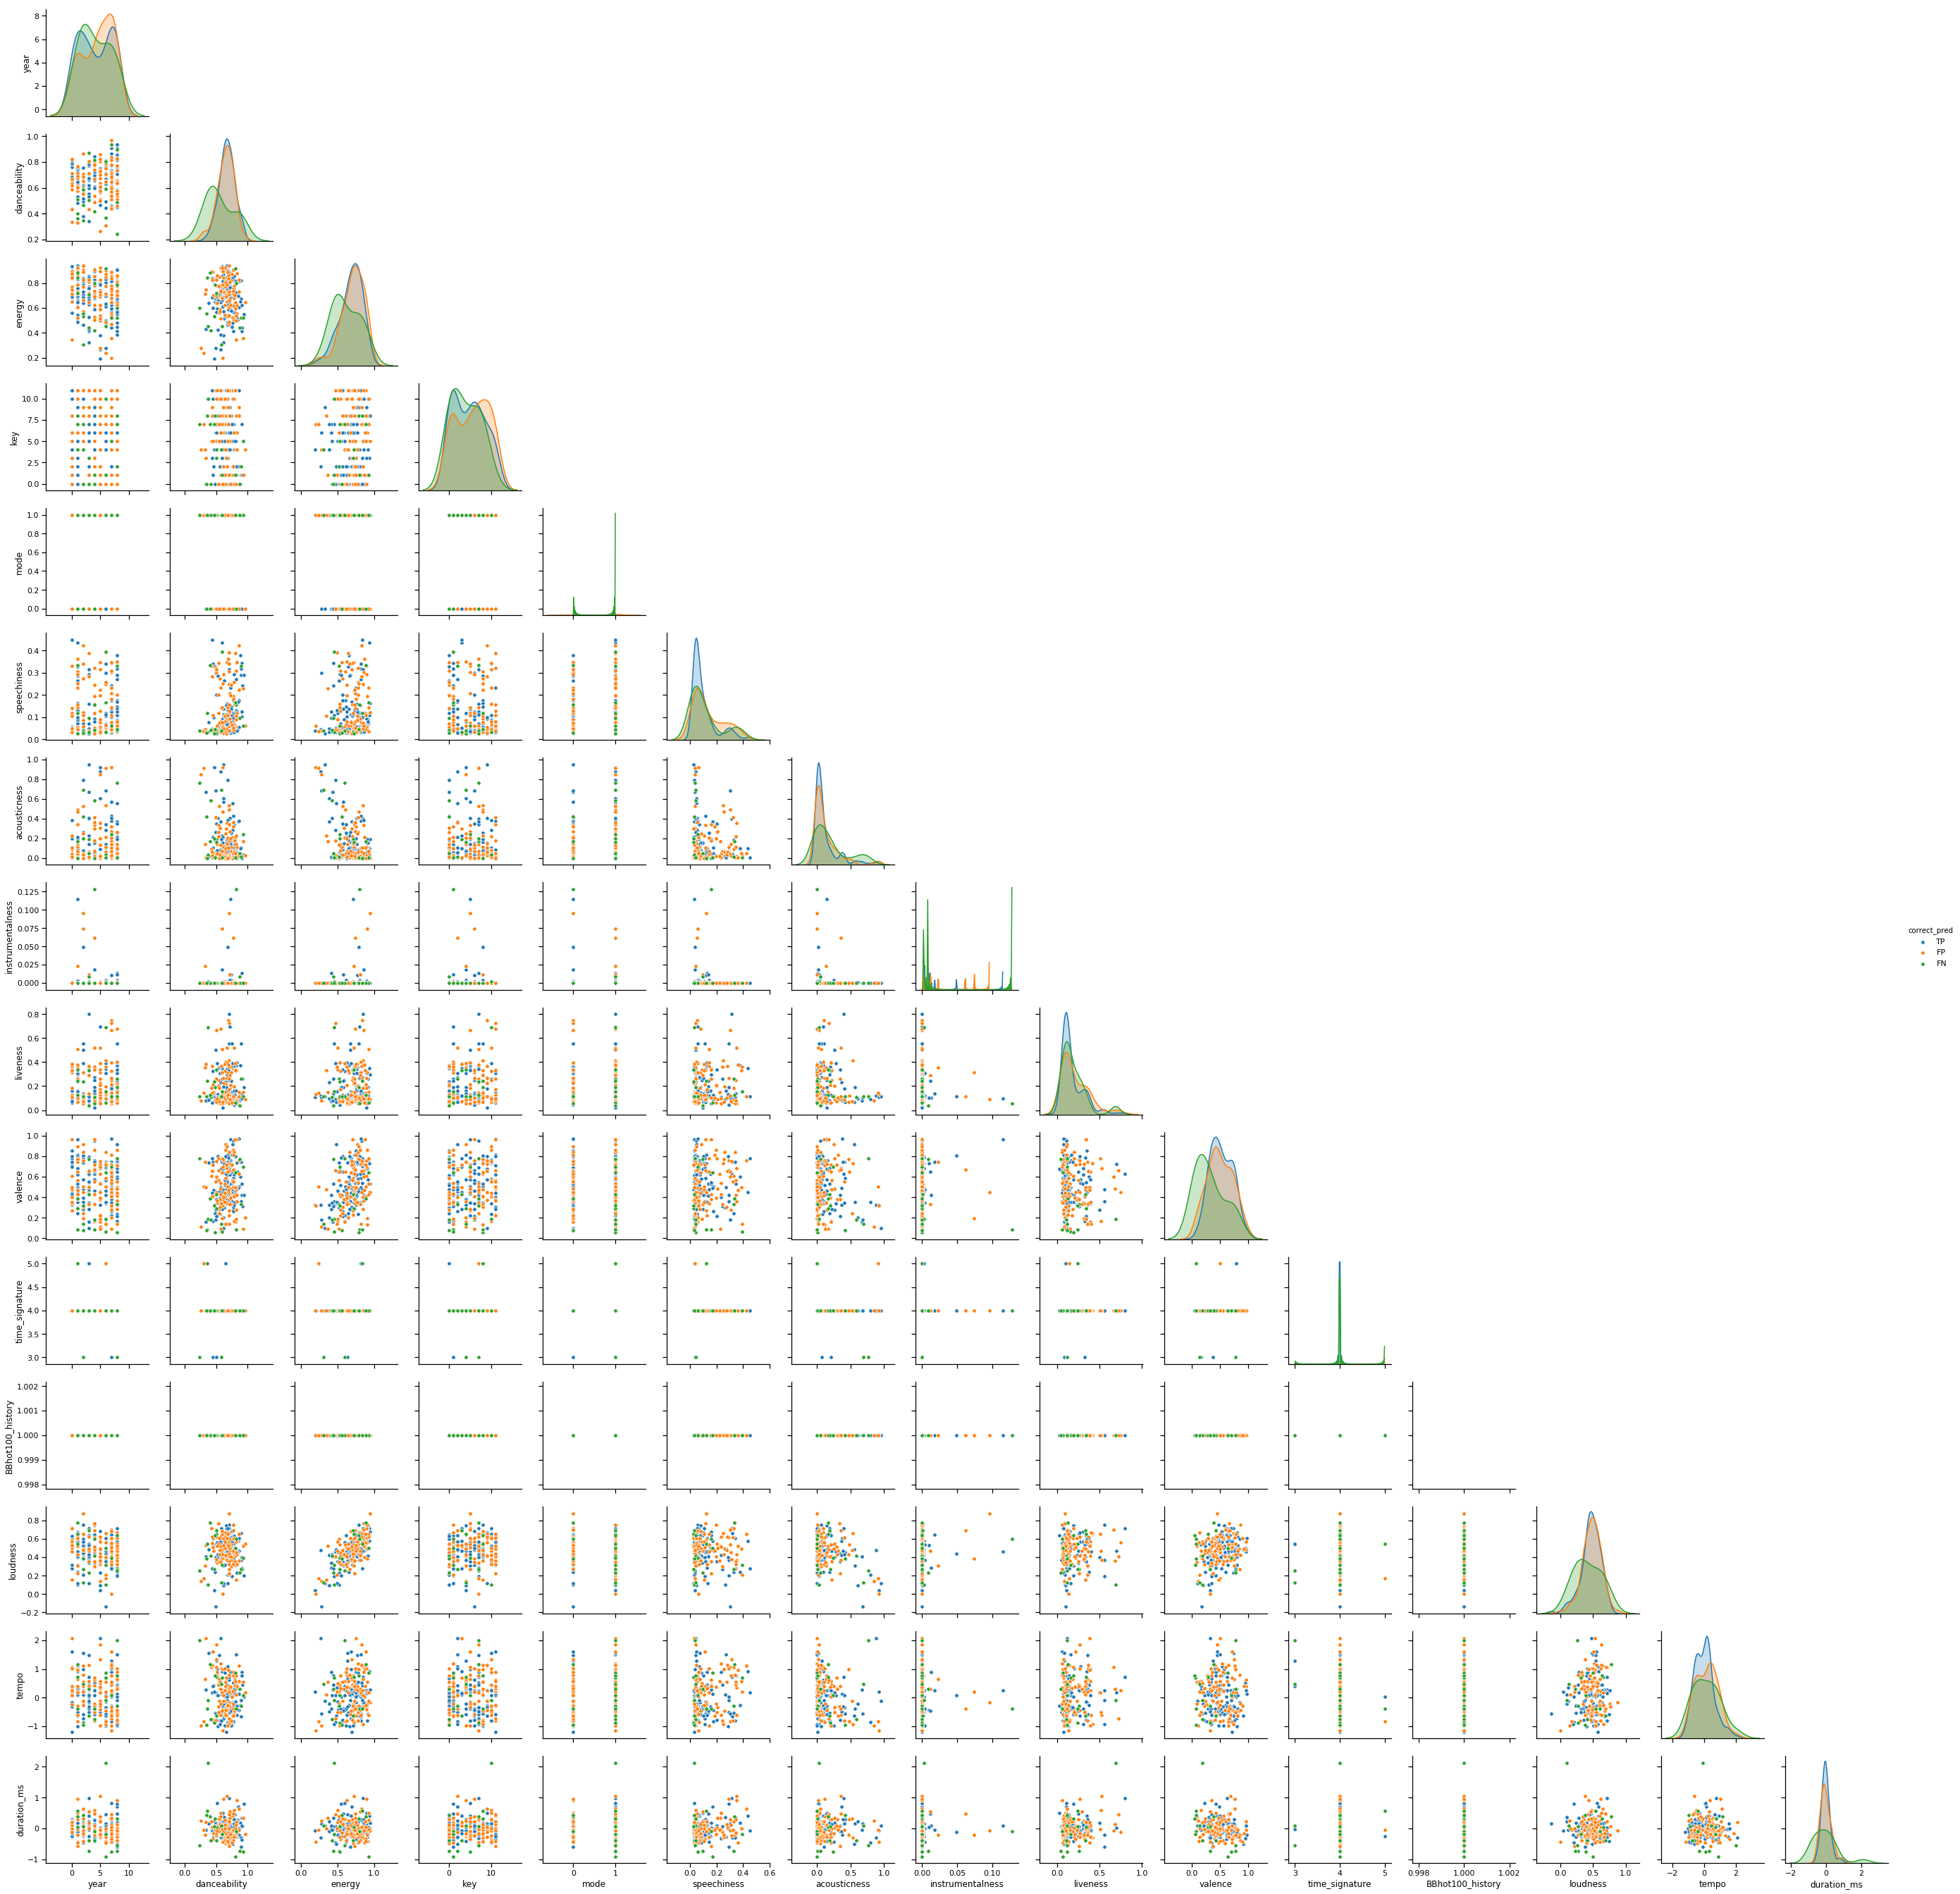

In [57]:
final_test_X_with_pred = final_test_X.copy()
final_test_X_with_pred = final_test_X_with_pred[~((pred_y==final_test_y)&(pred_y==0))]

pred_y_red = pred_y[~((pred_y==final_test_y)&(pred_y==0))]
test_y_red = final_test_y[~((pred_y==final_test_y)&(pred_y==0))]
                      
results_conditions = [((pred_y_red==1)&(test_y_red==0)), \
                      ((pred_y_red==0)&(test_y_red==1)), \
                      ((pred_y_red==1)&(test_y_red==1))]
results_choices = ['FP','FN','TP']

final_test_X_with_pred['correct_pred'] = np.select(results_conditions, results_choices)

s = sns.pairplot(final_test_X_with_pred, hue='correct_pred', plot_kws={"s": 30})
for i, j in zip(*np.triu_indices_from(s.axes, 1)):
    s.axes[i, j].set_visible(False)

In [92]:
final_test_X_with_pred[~((pred_y!=final_test_y)&(pred_y==1))].shape

/Users/jieunchoi/anaconda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(146, 16)

## Testing our Model with 2019 Data

In [58]:
def checkBB100hist(aid):
    with open('allartists_sp_id.csv', 'r') as fname:
        wr = csv.reader(fname)
        allartists_sp_id = [row[0] for row in wr]
    if (aid in allartists_sp_id):
        return 1
    else:
        return 0

In [59]:
def hitornot(artist='artist', track='track'):
    
    #initialize and read in necessary data
    client_credentials_manager = SpotifyClientCredentials(client_id='XXXXXX', client_secret='XXXXXX')
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    
    clf = load('hitornot_rfc_tuned.joblib') 
    with open('scaler.pickle', 'rb') as handle:
        sc = pickle.load(handle)
    
    #get artist and track id from Spotify
    search_result_1 = sp.search(q="artist:'"+artist+"'", type='artist', limit=1)
    aid = search_result_1["artists"]["items"][0]["id"].strip()
    aname = search_result_1["artists"]["items"][0]["name"].strip()
    
    search_result_2 = sp.search(q="artist:'"+artist+"'"+" track:'"+track+"'", type='track', limit=1)
    tid = search_result_2["tracks"]["items"][0]["id"].strip()
    tname = search_result_2["tracks"]["items"][0]["name"].strip()
    tyear = search_result_2["tracks"]["items"][0]["album"]["release_date"].split('-')[0]
    
    print(aname+': '+tname+' ('+tyear+')')
    
    #look up the audio features using the track id
    af = sp.audio_features(tracks=tid)[0]
    
    #build the data frame
    df_col_names = ['year' ,'danceability', 'energy', 'key', 'mode', 'speechiness', \
                    'acousticness', 'instrumentalness', 'liveness', 'valence', \
                    'time_signature', 'BBhot100_history', 'loudness', 'tempo', 'duration_ms']
    
    af_dict = {'year':int(tyear)-2010} 
    af_dict.update({'BBhot100_history':checkBB100hist(aid)})

    for c in df_col_names:
        if c in af.keys():
            af_dict.update({c:af[c]})
    
    af_df = pd.DataFrame(af_dict, index=[0])
    
    #scale some features
    scale_ind = [df_col_names.index(x) for x in ['loudness', 'tempo', 'duration_ms']]
    scaled_af_df = pd.DataFrame(sc.transform(af_df.iloc[:,scale_ind]), 
                                  columns = af_df.iloc[:,scale_ind].columns)
    
    noscale_ind = [df_col_names.index(x) for x in df_col_names if x not in ['loudness', 'tempo', 'duration_ms']]

    scaled_af_df = pd.concat([af_df.iloc[:,noscale_ind], scaled_af_df], axis=1)

    pred_y = clf.predict(scaled_af_df)

    if pred_y:
        print(track + ' by ' + artist + ' is predicted to be a hit')
    else:
        print(track + ' by ' + artist + ' is not predicted to be a hit')
        

A couple of tests with 2019 tracks. Going [down the list](https://www.billboard.com/charts/hot-100) in top 10, excluding tracks that are actually credited to 2018.

In [82]:
test_tracks = ['7 rings', 'please me', 'sucker', 'middle child', 'going bad']
test_artists = ['ariana grande', 'cardi b', 'jonas brothers', 'j. cole', 'meek mill']

for t in range(len(test_tracks)):
    hitornot(artist=test_artists[t], track=test_tracks[t])
    print('*'*50)


Ariana Grande: 7 rings (2019)
7 rings by ariana grande is not predicted to be a hit
**************************************************
Cardi B: Please Me (2019)
please me by cardi b is predicted to be a hit
**************************************************
Jonas Brothers: Sucker (2019)
sucker by jonas brothers is predicted to be a hit
**************************************************
J. Cole: MIDDLE CHILD (2019)
middle child by j. cole is not predicted to be a hit
**************************************************
Meek Mill: Going Bad (feat. Drake) (2018)
going bad by meek mill is not predicted to be a hit
**************************************************


## Conclusion

The goal of this project was to use Spotify's [audio features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) data to determine whether or not we could predict the popularity of a song released between 2010 and 2018. 

We first scraped data from the [Billboard archives](https://www.billboard.com/archive/charts) to obtain a list of hit songs and artists, then we looked up audio features for each of those songs. We also generated a pool of random songs, each with audio features data, to achieve a class balance of roughly 1%. 

EDA has revealed that popular songs tended to be high-energy, highly danceable, generally non-acoustic and non-instrumental. A bit surprisingly, hit songs are relatively broadly distributed along the valence (0: angry/sad/negative, 1: happy/cheery/positive) axis. We found a hint of evidence that popular songs are gradually moving away from the high-energy and high-valence end of the spectrum with time. Interesting follow-up work will be to extend this analysis further back in time to other decades *and* to monitor the trends in the future.

We explored different resampling strategies using [imbalanced-learn](http://imbalanced-learn.org/en/stable/user_guide.html) then performed nested CV to assess model performance and optimize the hyperparameters using GP to estimate the loss function as a function of the high-dimensional hyparameters-parameter space. We iterated several times to zoom in on a narrower region in this complicated, noisy high-dimensional search space. 

There may be marginal improvement with better hyperparameter optimization, but this may be an inherently difficult problem: it's actually really hard to predict the popularity of a song! For one, it's possible that music trends change over ~decade long timescale ([interesting NYT article](https://www.nytimes.com/interactive/2018/08/09/opinion/do-songs-of-the-summer-sound-the-same.html)). We tried to capture this by including the year as a feature, but maybe it's too noisy and would benefit from binning (e.g., early 2010s, late 2010s). Furthermore, we may need more features to be able to separate the TPs from the FP. One possibly helpful factor is a measure of total album sales (or # song downloads) for an artist to date (e.g., artist's sales up until 2016 for a song released in 2016).